## IGO17402 - KP R26-mTmG; Slc4a11-MCD mice exposed to Tamoxifen for 3d at 6 weeks
6/24/2025 - Data generated from 6 week KP Slc4a11-MCD/+ Rosa26 mTmG/+ tumors; data submitted by CHP/EB on 6/3/2025, analyzed by JC 6/24/2025

Analyze global run on cellranger v8 data and create h5_ad files for further analysis - w/o introns.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import math
import matplotlib
from matplotlib import pyplot as plt

from pathlib import Path
import anndata

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
#plt.rcParams['figure.figsize'] = (3,4)

In [4]:
#Path("./figures/umapfigures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [5]:
results_file = 'write/IGO17402-KP6wkmTmG3dTraced.h5ad'  # the file that will store the analysis results

Read in the count matrix into an [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5 file format: `.h5ad`.

In [6]:
adata = sc.read_10x_h5('GSE277777_IGO17402-filtered_feature_bc_matrix.h5', gex_only=False)

reading GSE277777_IGO17402-filtered_feature_bc_matrix.h5
 (0:00:00)


/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [8]:
samples = list(adata[:,adata.var['feature_types']=='Antibody Capture'].var.index)

In [9]:
# Now filter out barcodes
hashadata = adata[:,samples]
adata = adata[:,[y for y in adata.var_names if y not in samples]]

In [10]:
hashadata.var

gene_ids     feature_types genome  \
BO1534_B0301  BO1534_B0301  Antibody Capture          
BO1535_B0302  BO1535_B0302  Antibody Capture          
BO1540_B0303  BO1540_B0303  Antibody Capture          
BR1615_B0304  BR1615_B0304  Antibody Capture          
BS1265_B0305  BS1265_B0305  Antibody Capture          
BR1311_B0306  BR1311_B0306  Antibody Capture          
BR1128_B0307  BR1128_B0307  Antibody Capture          
BQ1151_B0308  BQ1151_B0308  Antibody Capture          
BQ1152_B0309  BQ1152_B0309  Antibody Capture          

                                pattern read         sequence  
BO1534_B0301  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  ACCCACCAGTAAGAC  
BO1535_B0302  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  GGTCGAGAGCATTCA  
BO1540_B0303  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  CTTGCCGCATGTCAT  
BR1615_B0304  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  AAAGCATTCTTCACG  
BS1265_B0305  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  CTTTGTCTTTGTGAG  
BR1311_B0306  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  TATGCTGCCACGGTA  
BR1128_B0307  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  GAGTCTGCCAGTATC  
BQ1151_B0308  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  TATAGAACGCCAGGC  
BQ1152_B0309  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  TGCCTATGAAACAAG

## Preprocessing

/Users/chanj2/opt/miniconda3/envs/scbackup/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:208: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


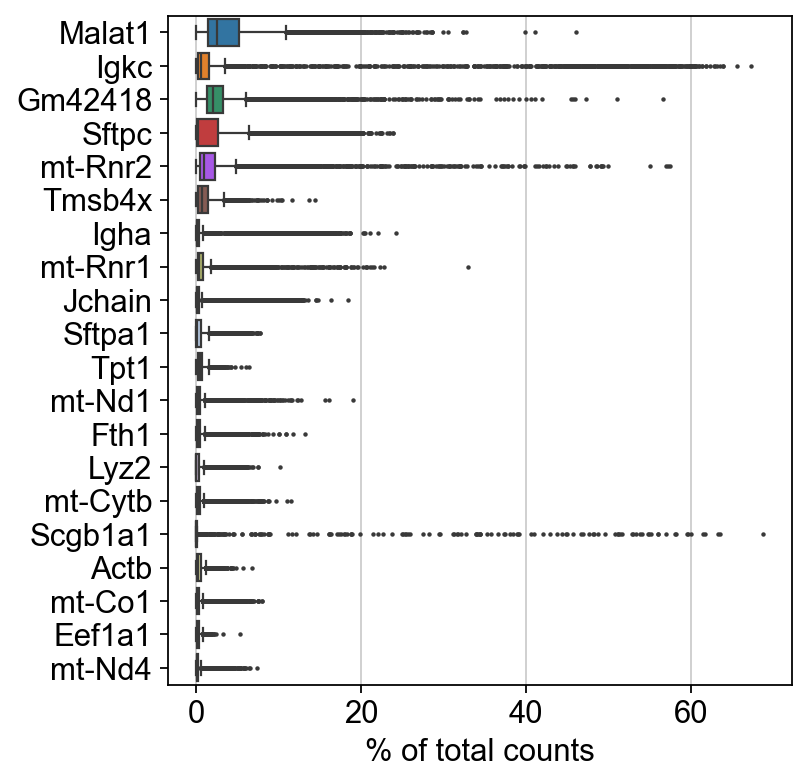

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [12]:
sc.pp.filter_cells(adata, min_counts=1500)
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 3478 cells that have less than 1500 counts
filtered out 8 cells that have less than 300 genes expressed
filtered out 32540 genes that are detected in less than 3 cells


In [13]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

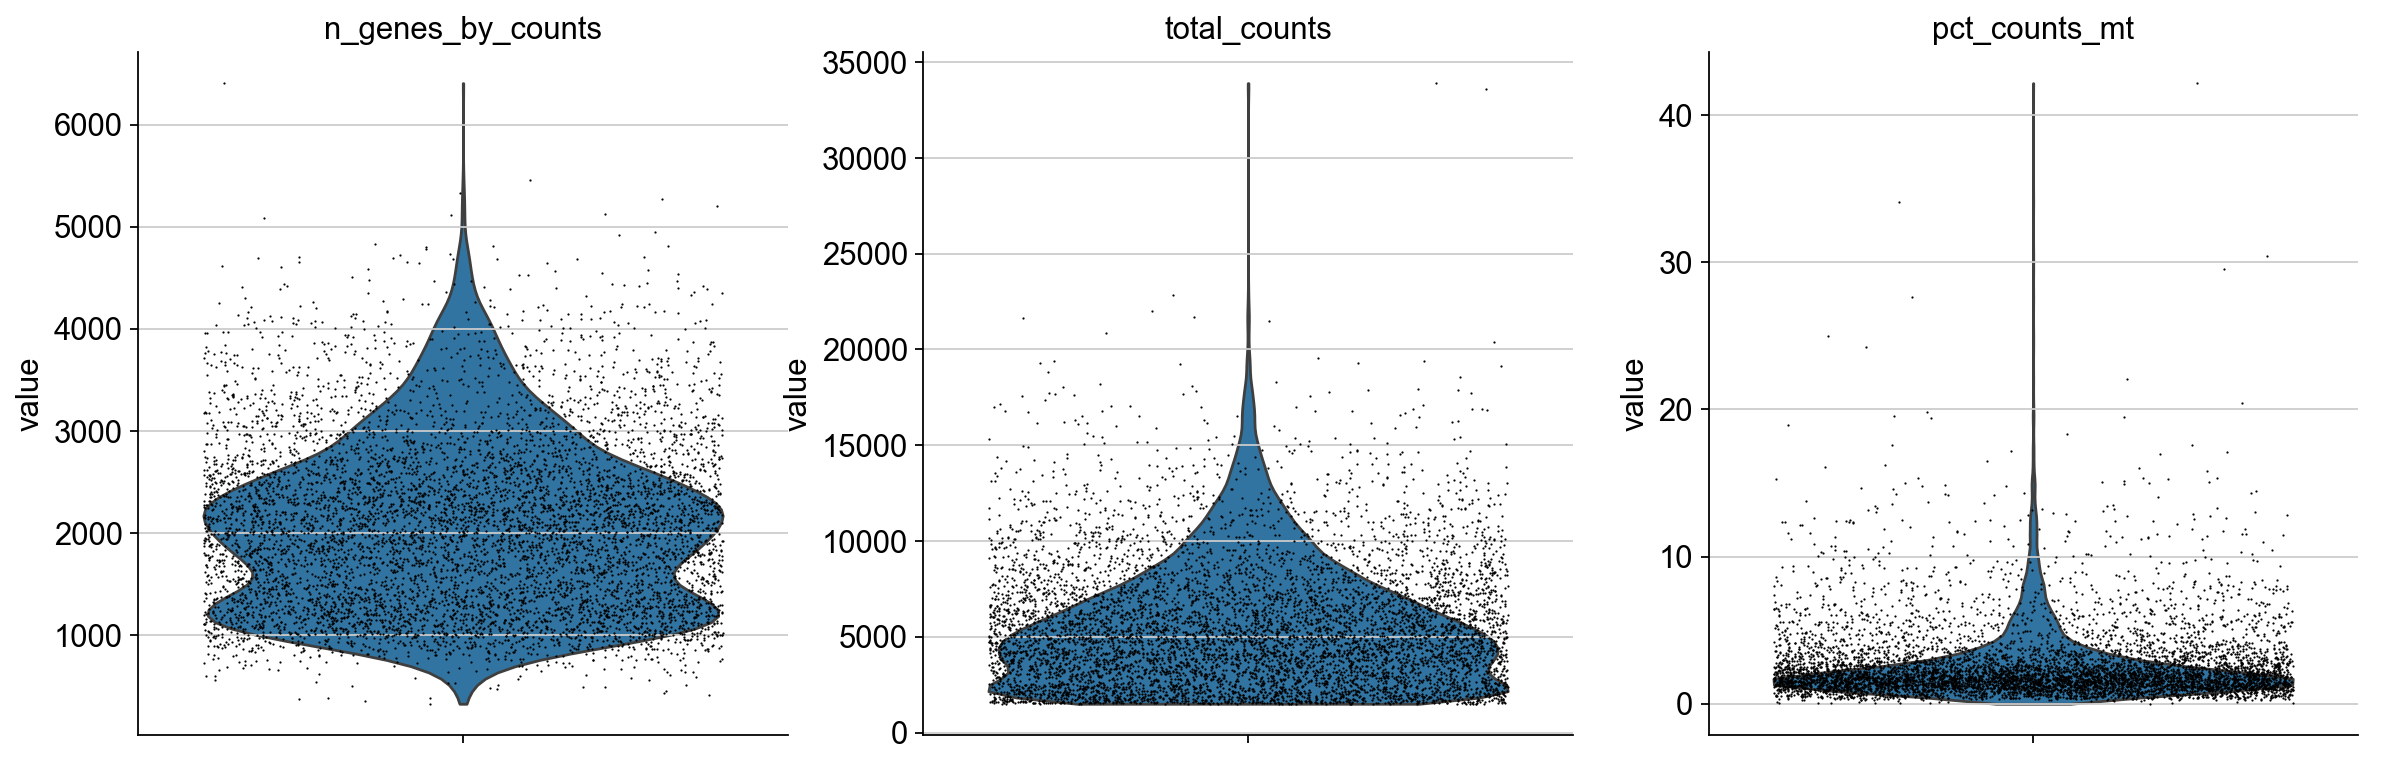

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

(array([  41.,  196.,  189.,   94.,   78.,  163., 1353., 2349., 2077.,
         528.]),
 array([0.73794912, 0.75942688, 0.78090465, 0.80238241, 0.82386018,
        0.84533794, 0.86681571, 0.88829347, 0.90977123, 0.931249  ,
        0.95272676]),
 <BarContainer object of 10 artists>)

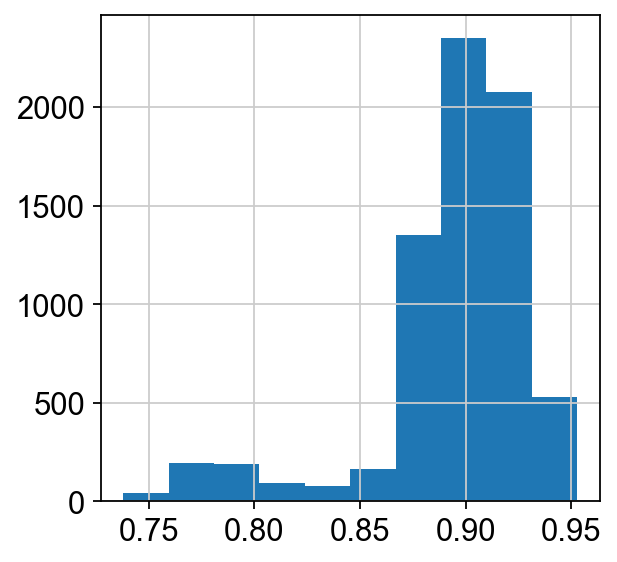

In [15]:
adata.obs["log10GenesPerUMI"] = adata.obs['n_genes_by_counts'].apply(math.log10) / adata.obs['total_counts'].apply(math.log10)
matplotlib.pyplot.hist(adata.obs["log10GenesPerUMI"])

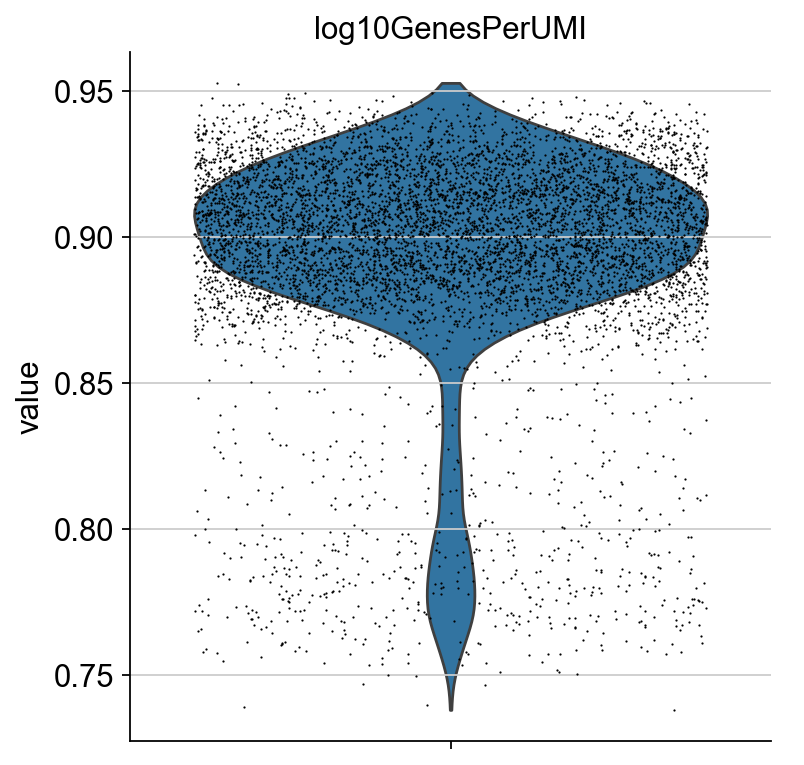

In [16]:
sc.pl.violin(adata, ['log10GenesPerUMI'],
             jitter=0.4, multi_panel=True, rotation=90)

In [17]:
#Filter by Log10GenesPerUMI
adata = adata[adata.obs.log10GenesPerUMI >= 0.8,:]

In [18]:
adata = adata[adata.obs.pct_counts_mt <= 10, :]

## Run Demultiplexing

In [19]:
hashadata = hashadata[hashadata.obs.index.isin(adata.obs.index), :]

In [20]:
hashadata.var_names

Index(['BO1534_B0301', 'BO1535_B0302', 'BO1540_B0303', 'BR1615_B0304',
       'BS1265_B0305', 'BR1311_B0306', 'BR1128_B0307', 'BQ1151_B0308',
       'BQ1152_B0309'],
      dtype='object')

In [21]:
hashCounts = pd.DataFrame(hashadata.X.todense(), columns=hashadata.var_names, index=adata.obs.index)

In [22]:
hashDisc = hashCounts.describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,0.99])
#hashDisc

In [23]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(hashDisc.loc["90%",hashName])
    hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
#hashIDs

BO1534_B0301
1829.2000000000007
BO1535_B0302
7.0
BO1540_B0303
3.0
BR1615_B0304
7.0
BS1265_B0305
5.0
BR1311_B0306
33.0
BR1128_B0307
1.0
BQ1151_B0308
524.6000000000004
BQ1152_B0309
103.80000000000018


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85349/4170078627.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85349/4170078627.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85349/4170078627.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise 

In [24]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['figure.figsize'] = (3,4)

BO1534_B0301
BO1535_B0302
BO1540_B0303
BR1615_B0304
BS1265_B0305
BR1311_B0306
BR1128_B0307
BQ1151_B0308
BQ1152_B0309


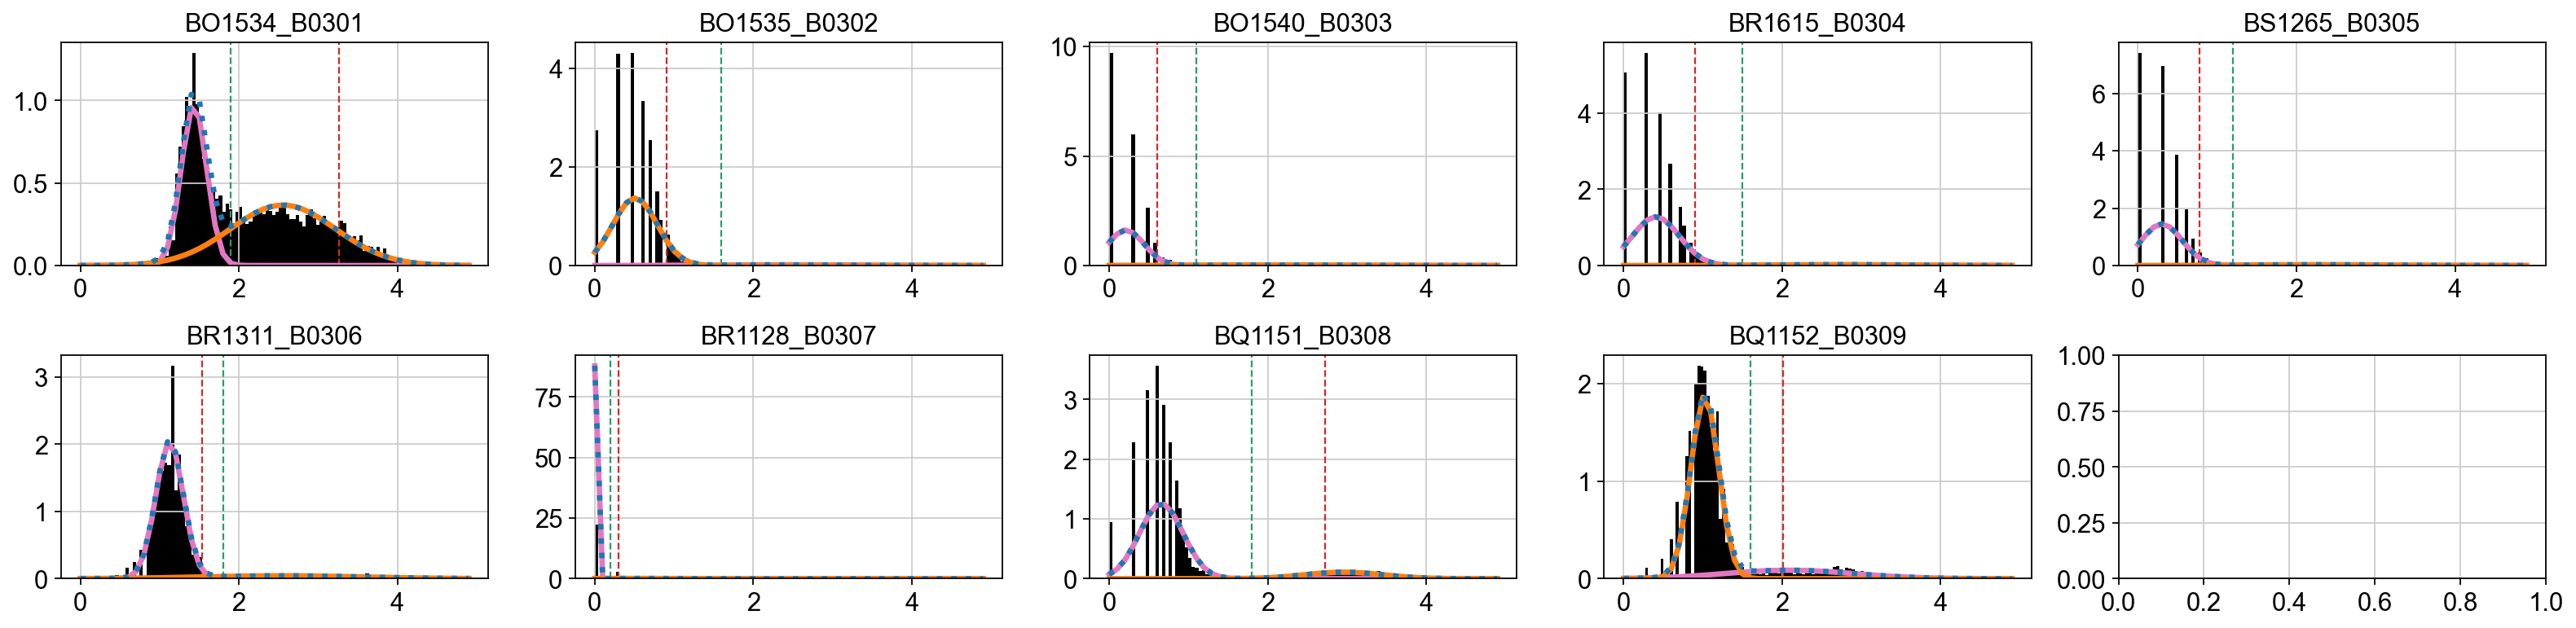

In [25]:
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import norm
fig, axs = plt.subplots(2,5, figsize =(20, 5))
dfHashBoundry = pd.DataFrame(np.zeros(len(hashadata.var_names)),hashadata.var_names, columns=["boundry"])
gmm = BayesianGaussianMixture(n_components=2, random_state=250,init_params='k-means++')
binEx = np.arange(0,5,5/100).reshape(-1,1)

for i, hashName in enumerate(hashadata.var_names):
    hashCount = np.array(np.log10(hashCounts[hashName]+1)).reshape(-1, 1)
    fitGMM = gmm.fit(hashCount)
    mean = fitGMM.means_  
    covs  = fitGMM.covariances_
    weights = fitGMM.weights_
  
    fitGmmBound = fitGMM.predict(binEx)

    x_axis = np.arange(0, 5, 0.1)
    y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
    y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

    hashBoundry = False #binEx[np.where(fitGmmBound == 1)[0][0]][0]  
    print(hashName)
    if mean[0][0] < mean[1][0] and (((y_axis1 < y_axis0)[0] == False and sum(v1 != v2 for v1, v2 in zip(y_axis1 < y_axis0, (y_axis1 < y_axis0)[1:])) % 2 == 0) or 
    sum(v1 != v2 for v1, v2 in zip(y_axis1 < y_axis0, (y_axis1 < y_axis0)[1:])) == 1):
        hashBoundry = x_axis[np.where(y_axis1 < y_axis0)[0][-1]+2]
    else:
        hashBoundry = x_axis[np.where(y_axis0 < y_axis1)[0][-1]+2]
    
    naiveBoundry = np.log10(int(hashDisc.loc["90%",hashName])+1)
    
    dfHashBoundry.loc[hashName] = hashBoundry
    
    # Plot 2
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].axvline(naiveBoundry, c='C3', linestyle='dashed', linewidth=1) #red
    axs[i//5,i%5].axvline(hashBoundry, c='C2', linestyle='dashed', linewidth=1)  #green
    axs[i//5,i%5].hist(hashCount, density=True, color='black', bins=100)        
    axs[i//5,i%5].plot(x_axis, y_axis0, lw=3, c='C6')                            #pink
    axs[i//5,i%5].plot(x_axis, y_axis1, lw=3, c='C1')                            #orange
    axs[i//5,i%5].plot(x_axis, y_axis0+y_axis1, lw=3, c='C0', ls=':')            #dotted blue
    
plt.tight_layout(pad=1.0)
#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

In [26]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
#set manual minimum threshold to be 0.5
for hashName in hashadata.var_names:
    print(hashName)
    print(dfHashBoundry.loc[hashName].values[0])
    #manually set minimum threshold to 0.5 given poor HashData
    if (dfHashBoundry.loc[hashName].values[0] < 1):
        dfHashBoundry.loc[hashName].values[0] = 1
    print(dfHashBoundry.loc[hashName].values[0])
    hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
#hashIDs

BO1534_B0301
1.9000000000000001
1.9000000000000001
BO1535_B0302
1.6
1.6
BO1540_B0303
1.1
1.1
BR1615_B0304
1.5
1.5
BS1265_B0305
1.2000000000000002
1.2000000000000002
BR1311_B0306
1.8
1.8
BR1128_B0307
0.2
1.0
BQ1151_B0308
1.8
1.8
BQ1152_B0309
1.6
1.6


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85349/2024925687.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85349/2024925687.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85349/2024925687.py:11: FutureWarning: Setting an item of inc

In [27]:
classification = np.empty(len(adata), dtype="object")
i = 0
for cellBar, hashBool in hashIDs.iterrows():
    numHashes = sum(hashBool)
    if (numHashes == 1):
        classif = hashID[hashBool.values].values[0]
    elif (numHashes > 1):
        classif = "doublet"
    else:
        classif = "negative"
    classification[i] = classif
    i = i + 1
    #break

In [28]:
adata.obs["Classification"] = classification
hashadata.obs["Classification"] = classification
adata.obs["Classification"].value_counts()

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85349/4135005838.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Classification"] = classification
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85349/4135005838.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hashadata.obs["Classification"] = classification


Classification
BO1534_B0301    2699
doublet          792
negative         738
BQ1151_B0308     617
BQ1152_B0309     550
BR1311_B0306     333
BS1265_B0305     231
BO1540_B0303     200
BR1615_B0304     191
BO1535_B0302     112
BR1128_B0307      30
Name: count, dtype: int64

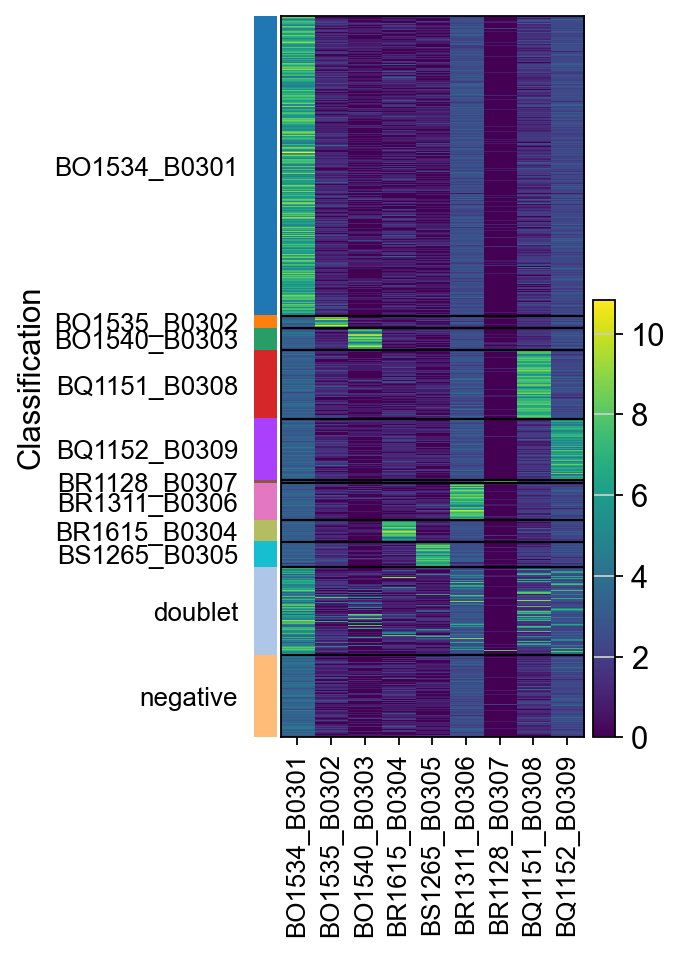

In [29]:
#output visulaization of hashing
sc.pl.heatmap(hashadata, hashadata.var_names, groupby="Classification", log=True)#, save = f"_{figName}_hash.png")

## set highly variable genes before moving all mean to 0

In [30]:
adata.var.index

Index(['Xkr4', 'Gm37180', 'Gm37329', 'Gm19938', 'Gm37381', 'Rp1', 'Gm37483',
       'Sox17', 'Gm6085', 'Gm6119',
       ...
       'AC149090.1', 'CAAA01118383.1', 'CAAA01147332.1', 'tdTomato', 'EGFP',
       'mScarlet', 'Cre', 'ERT', 'iDTR', 'Akaluc'],
      dtype='object', length=22309)

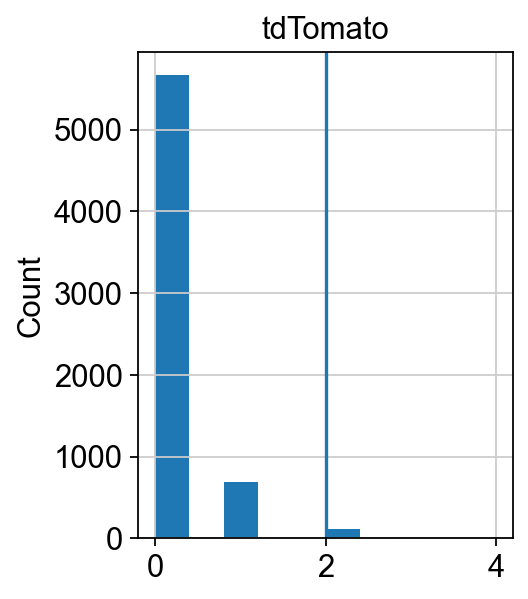

In [31]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['tdTomato'])].toarray())
plt.ylabel("Count")
plt.title("tdTomato")
plt.axvline(x=2)
plt.show()

In [32]:
adata.obs['tdTomato_count'] = adata.X[:,adata.var.index.isin(['tdTomato'])].toarray()

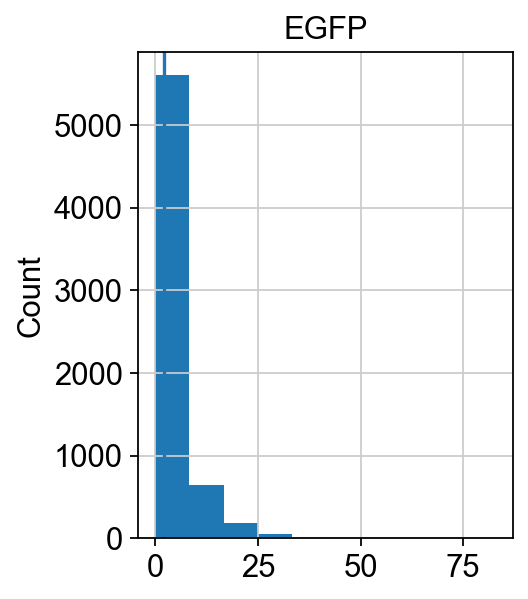

In [33]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['EGFP'])].toarray())
plt.ylabel("Count")
plt.title("EGFP")
plt.axvline(x=2)
plt.show()

In [34]:
adata.obs['EGFP_count'] = adata.X[:,adata.var.index.isin(['EGFP'])].toarray()

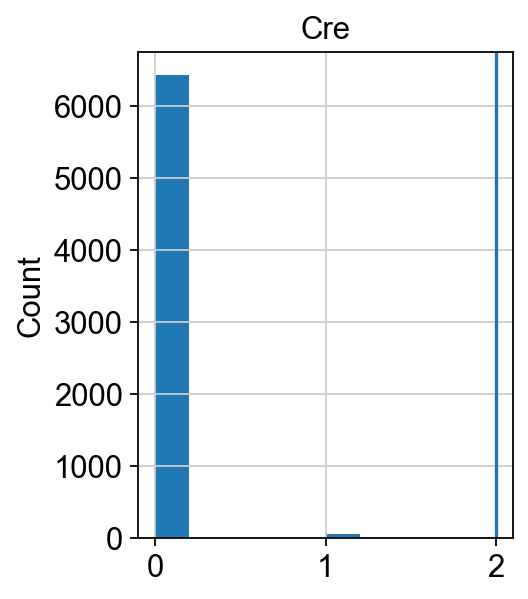

In [35]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['Cre'])].toarray())
plt.ylabel("Count")
plt.title("Cre")
plt.axvline(x=2)
plt.show()

In [36]:
adata.obs['Cre_count'] = adata.X[:,adata.var.index.isin(['Cre'])].toarray()

## Filter doublets and negative cells

In [37]:
adata.obs.Classification.value_counts()

Classification
BO1534_B0301    2699
doublet          792
negative         738
BQ1151_B0308     617
BQ1152_B0309     550
BR1311_B0306     333
BS1265_B0305     231
BO1540_B0303     200
BR1615_B0304     191
BO1535_B0302     112
BR1128_B0307      30
Name: count, dtype: int64

In [38]:
adata = adata[~adata.obs['Classification'].isin(['doublet','negative']),:]

In [39]:
adata.obs.Classification.value_counts()

Classification
BO1534_B0301    2699
BQ1151_B0308     617
BQ1152_B0309     550
BR1311_B0306     333
BS1265_B0305     231
BO1540_B0303     200
BR1615_B0304     191
BO1535_B0302     112
BR1128_B0307      30
Name: count, dtype: int64

## Set Groups

In [40]:
samples

['BO1534_B0301',
 'BO1535_B0302',
 'BO1540_B0303',
 'BR1615_B0304',
 'BS1265_B0305',
 'BR1311_B0306',
 'BR1128_B0307',
 'BQ1151_B0308',
 'BQ1152_B0309']

In [41]:
#Set groups
#BO1016_GFP has Akaluc (BO1016_BFP does not)
adata.obs['Group'] = '6wk3d'
#adata.obs['Allele'] = 'Slc4a11'
adata.obs['Group'][adata.obs.Classification.isin(['BQ1151_B0308',
                                                   'BQ1152_B0309'])] = 'Hopx_12wk3d'
adata.obs['Group'][adata.obs.Classification.isin(['BO1534_B0301'])] = 'Carrier'

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85349/857774862.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Group'] = '6wk3d'
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85349/857774862.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https

In [42]:
adata.layers['counts']=adata.X.copy()

In [43]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [44]:
sc.pp.log1p(adata)

In [45]:
sc.pp.highly_variable_genes(adata) #batch_key=Classification

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


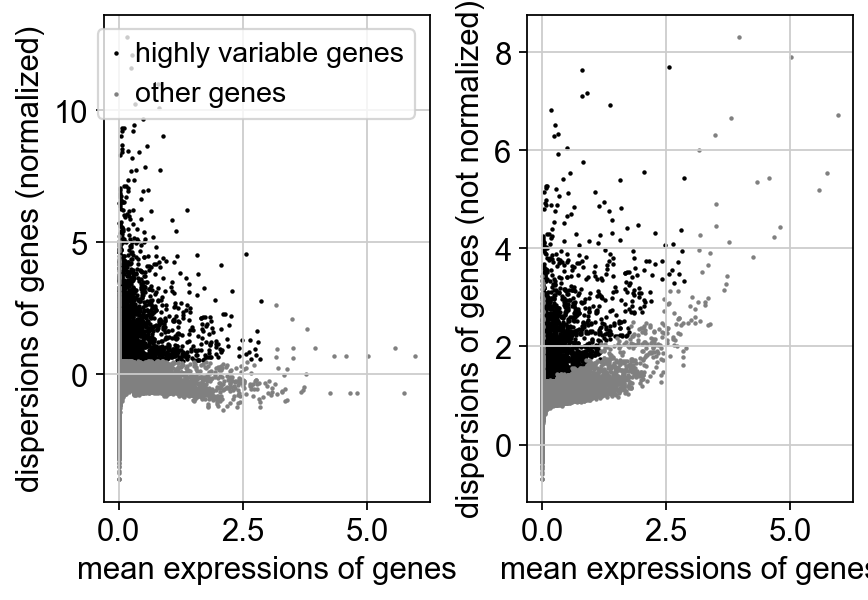

In [46]:
sc.pl.highly_variable_genes(adata)

In [47]:
#will need to update this after realignment
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tagBFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Akaluc'] = False
adata.var.highly_variable['tdTomato'] = False
adata.var.highly_variable['GLuc'] = False
adata.var.highly_variable['CLuc'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85349/2467826253.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85349/246782

In [48]:
adata.raw = adata

In [49]:
adata.write('write/allmice-IGO17402.h5ad', compression='gzip')

In [50]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


## Principal component analysis

In [51]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=150)

computing PCA
    with n_comps=150
    finished (0:00:01)


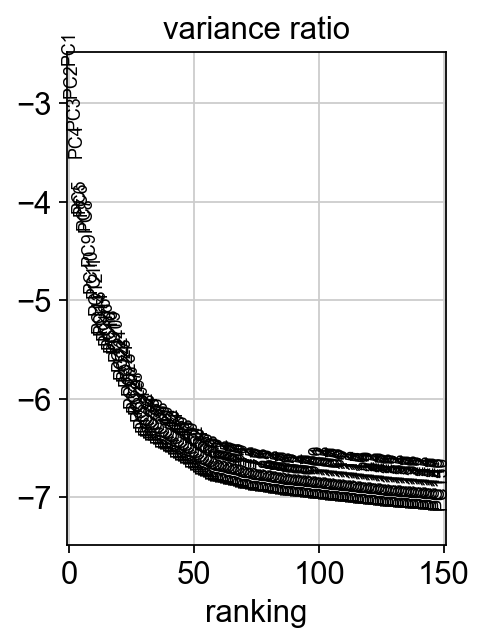

In [52]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=150)

Save the result.

In [53]:
adata.write(results_file, compression='gzip')

## Computing the neighborhood graph

In [54]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


## Embedding the neighborhood graph

In [55]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)


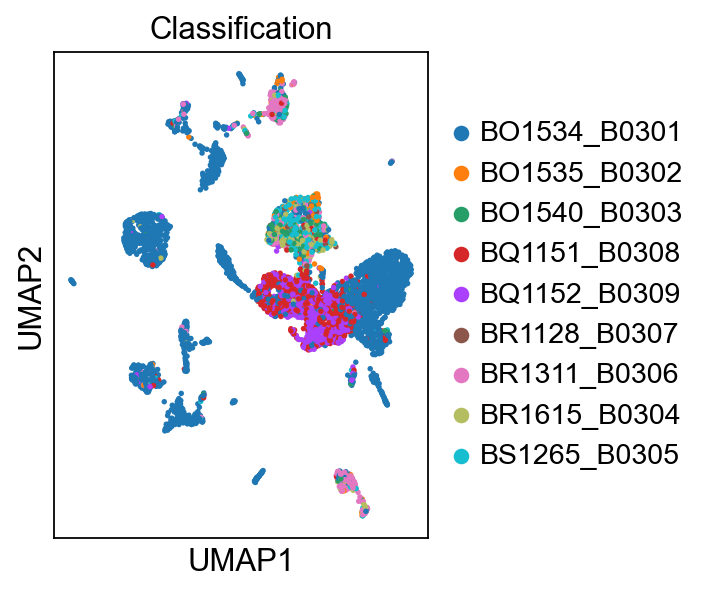

In [56]:
sc.pl.umap(adata, color=['Classification'])

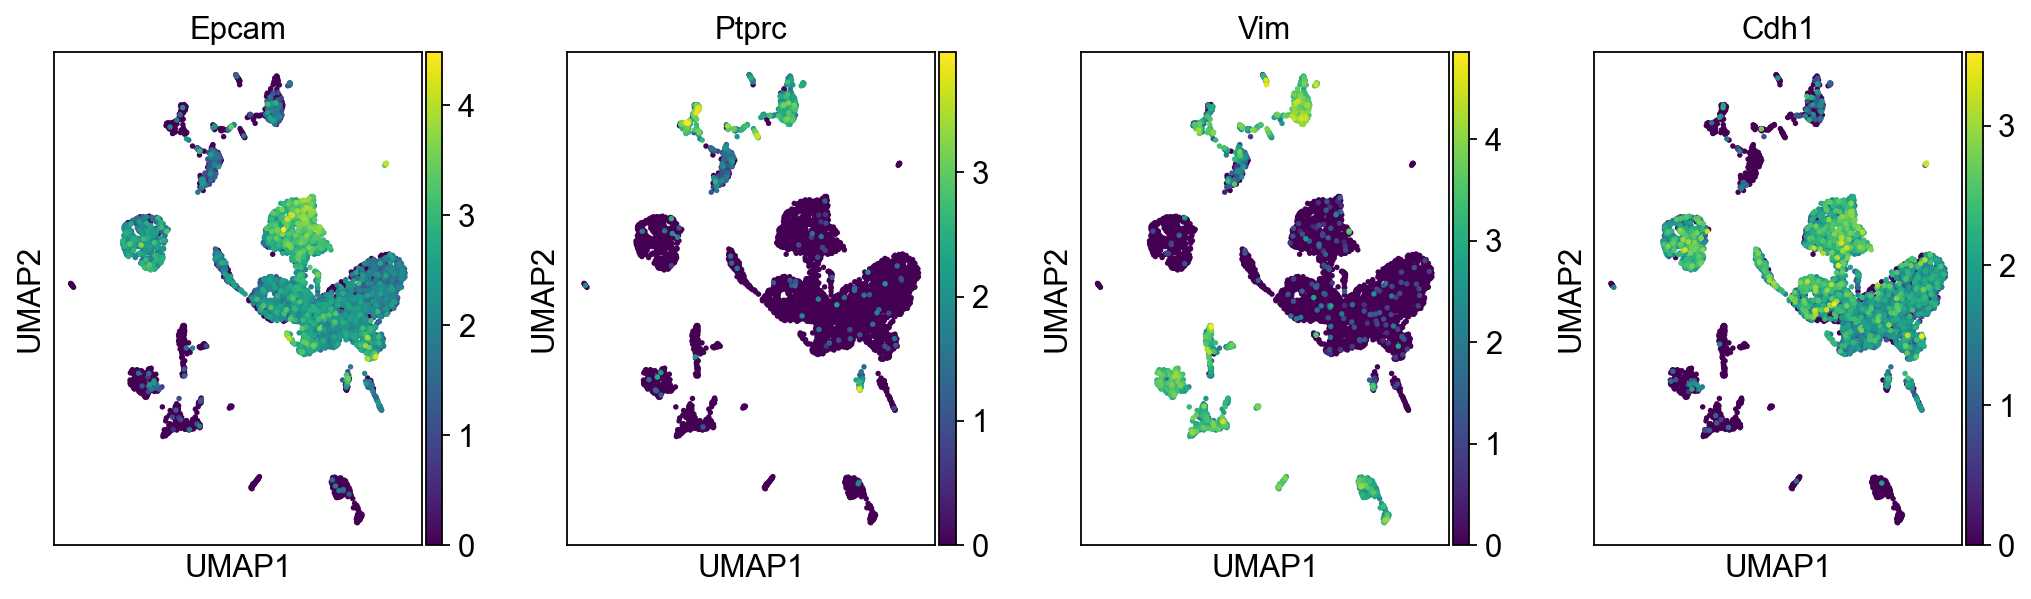

In [57]:
sc.pl.umap(adata, color=['Epcam','Ptprc','Vim', 'Cdh1',]) #'Ptprc','Cdh2'

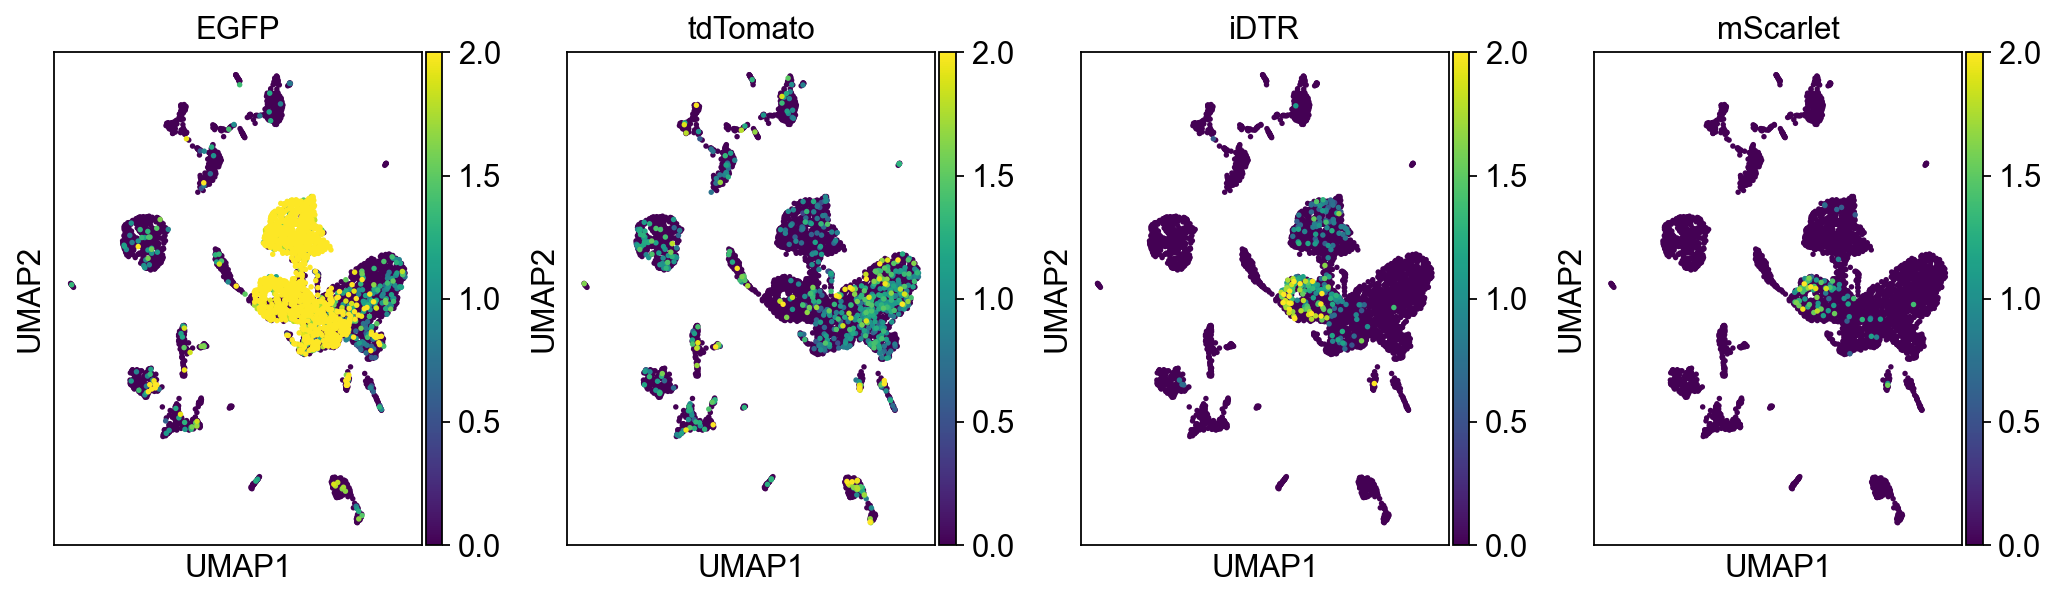

In [58]:
sc.pl.umap(adata, color=['EGFP','tdTomato','iDTR','mScarlet'], vmax=2)

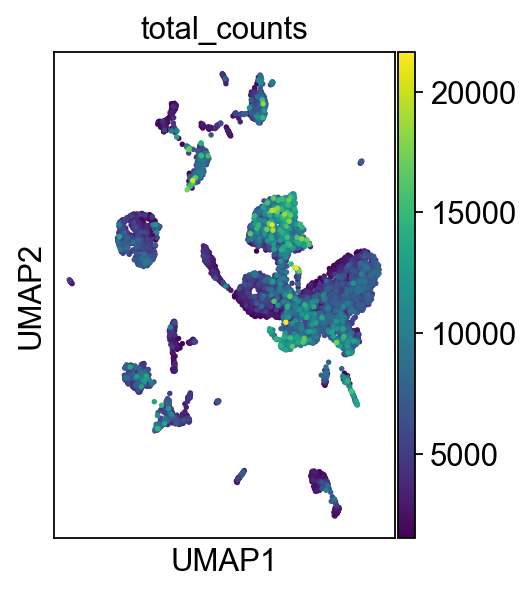

In [59]:
sc.pl.umap(adata, color=['total_counts'])

## Define scoring Functions

In [60]:
# Score Cluster 5 cells
import csv
clusters = {}
clusterkeys = []
HPCS = False

def resetClusters(hpcs = 'cell2020'):
    clusters = {}
    clusterkeys = []
    HPCS = False
    try:
        if hpcs == 'cell2020':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        else:
            raise ValueError
    except ValueError:
        print("%s is an invalid choice" % hpcs)
        raise
    return (clusters, clusterkeys, HPCS)

(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [61]:
def scoreAndPlot(ad, excludeList = None, groupby="Classification",rotation=90,numgenes=500,ctlgenes=25):
    #cmap = 'Reds' #colormap
    cmap = 'jet' #colormap
    if excludeList == None:
        for i in clusterkeys:
            if (numgenes > ctlgenes):
                ctlgenes = numgenes
            sc.tl.score_genes(ad, clusters[i][0:numgenes],score_name="%s" % i, ctrl_size=ctlgenes)  
  
        sc.pl.umap(ad, color=clusterkeys, color_map=cmap)
        sc.pl.dotplot(ad, clusterkeys, groupby=groupby, swap_axes=True)

In [62]:
from scipy.stats import ranksums

def HPCSViolinPlot(ad, cluster='0', groupby='leiden', score='Cluster5', save=None, singleGene=False):
    ad.obs['Cl5'] = 'not HPCS'
    ad.obs.loc[ad.obs[groupby].isin([cluster]), 'Cl5'] = 'HPCS'

    if singleGene:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray(),ad[~ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray())[1]
    else:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])].obs[score],ad[ad.obs['Cl5'].isin(['not HPCS'])].obs[score])[1]
    sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)

computing score 'Cluster 1'
    finished: added
    'Cluster 1', score of gene set (adata.obs).
    1892 total control genes are used. (0:00:00)
computing score 'Cluster 2'
    finished: added
    'Cluster 2', score of gene set (adata.obs).
    1493 total control genes are used. (0:00:00)
computing score 'Cluster 3'
    finished: added
    'Cluster 3', score of gene set (adata.obs).
    1487 total control genes are used. (0:00:00)
computing score 'Cluster 4'
    finished: added
    'Cluster 4', score of gene set (adata.obs).
    1793 total control genes are used. (0:00:00)
computing score 'Cluster 5'
    finished: added
    'Cluster 5', score of gene set (adata.obs).
    1693 total control genes are used. (0:00:00)
computing score 'Cluster 6'
       'Rps2-ps6', 'Fam46c', 'Gm6139', 'Gm10179', 'Gm5864'],
      dtype='object')
    finished: added
    'Cluster 6', score of gene set (adata.obs).
    1988 total control genes are used. (0:00:00)
computing score 'Cluster 7'
    finished: added

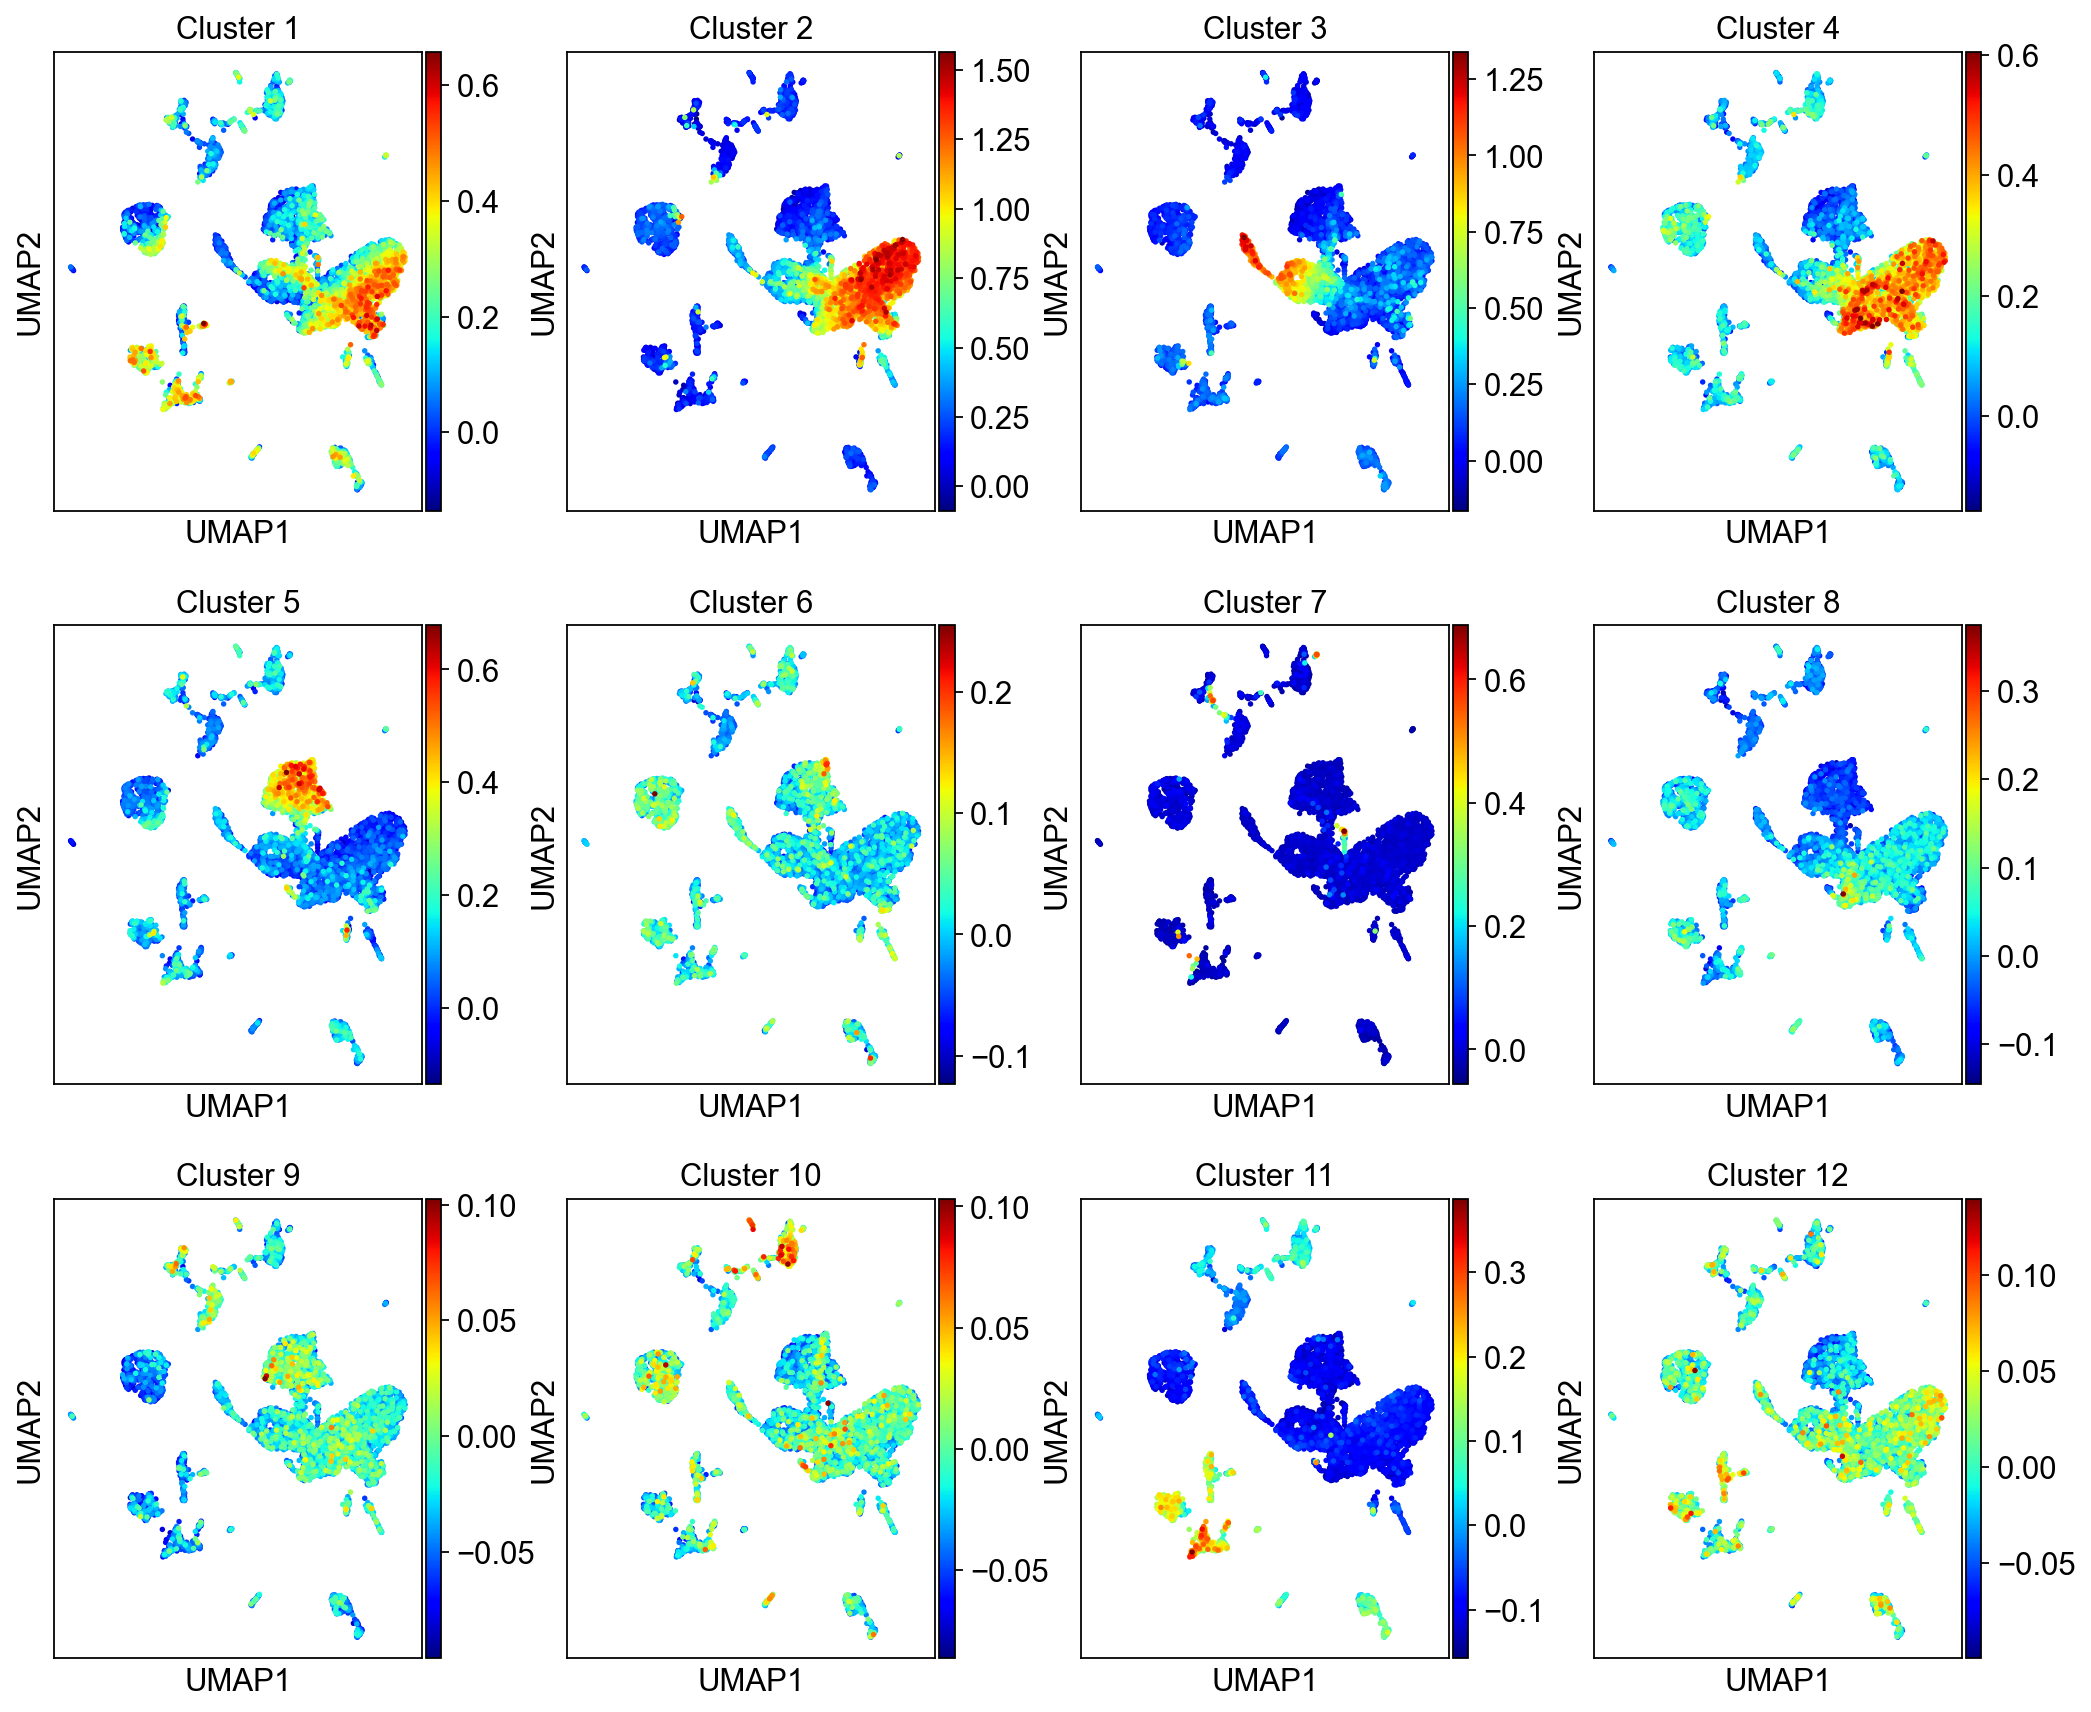

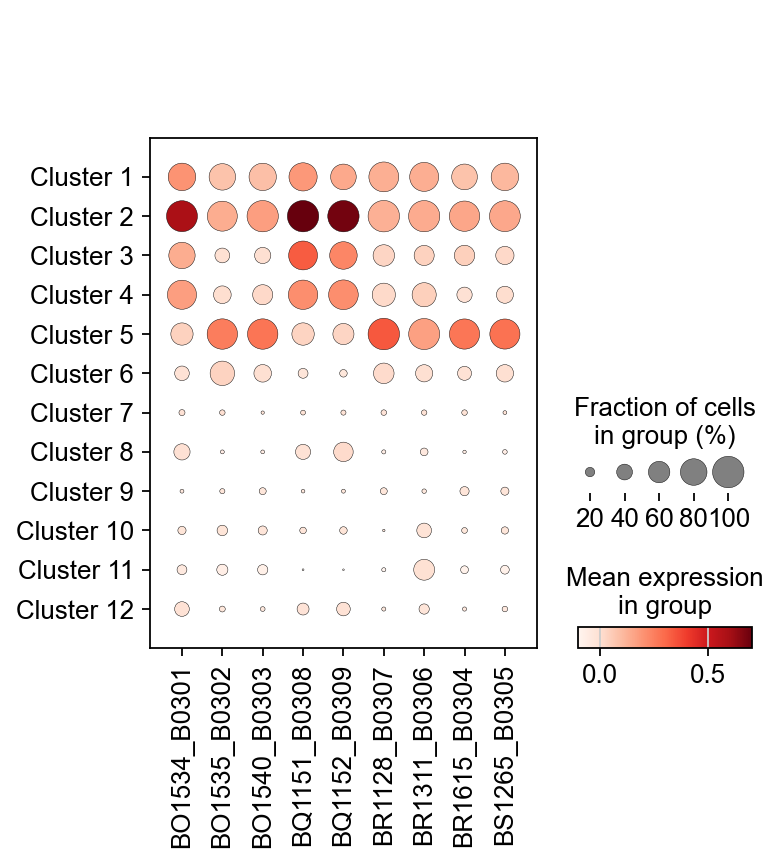

In [63]:
scoreAndPlot(adata, numgenes=100)

## Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [64]:
sc.tl.leiden(adata, resolution=.25)

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85349/1592280972.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=.25)


Plot the clusters, which agree quite well with the result of Seurat.

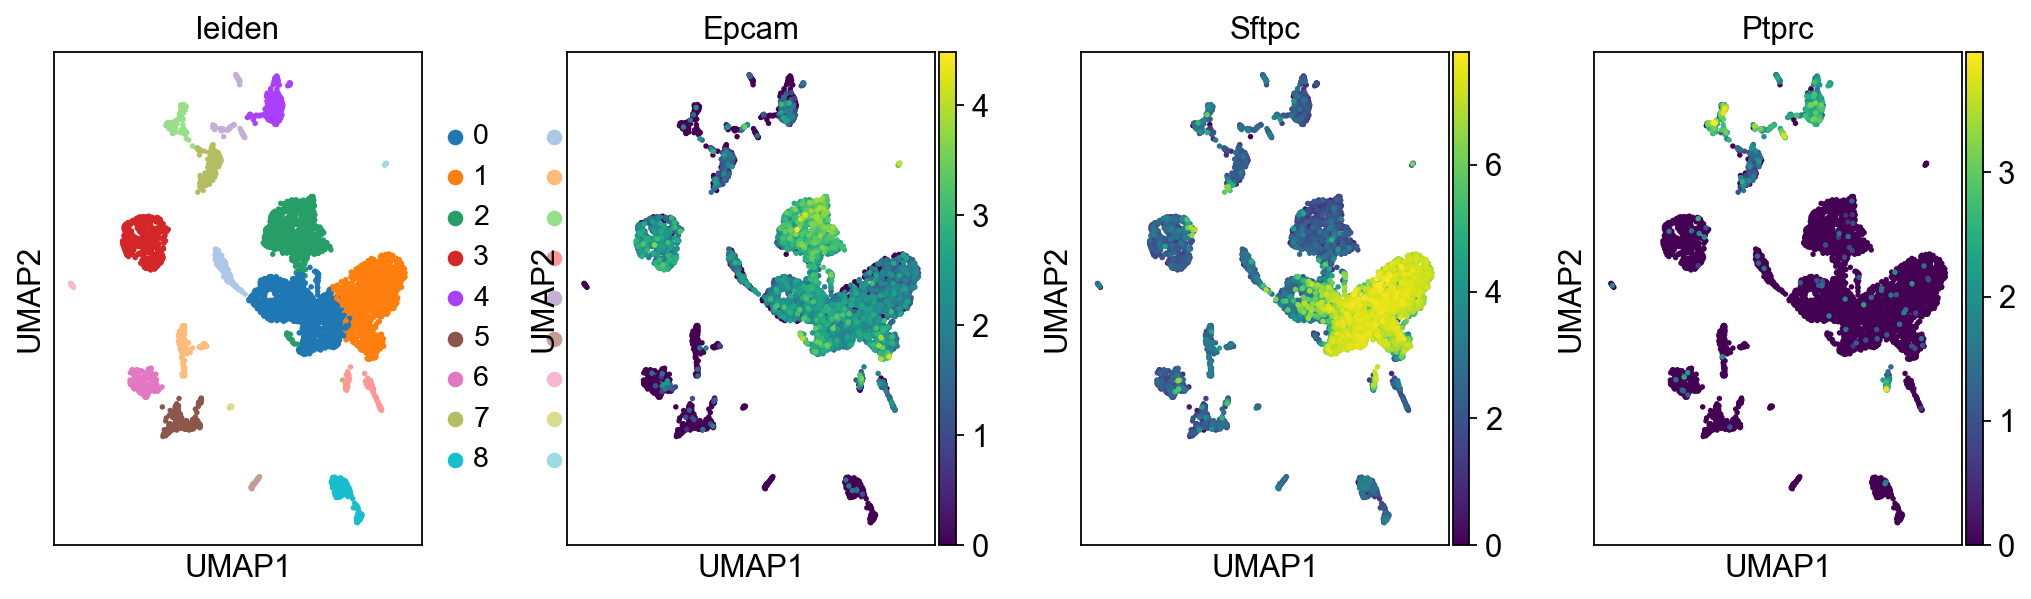

(None,)

In [65]:
sc.pl.umap(adata, color=['leiden', 'Epcam', 'Sftpc', # Tumor cells
                         'Ptprc']), #immune
                         #  'Cd4', 'Cd8a', #T cell #'Cd3e',
                         # 'Cd19', 'Ms4a1', 'Cd22', # B cell
                         # #'Itgax', 'Il3ra', # Dendritic Cell
                         # 'Ncam1',# 'Ncr1', # NK Cell
                         # 'Cd34', # Hematopoetic stem cell
                         # #'Cd14', 'Cd33', # macrophage
                         # #'Ceacam8' # Granulocyte
                         # 'Itga2b', 'Itgb3', 'Selp', #platelet
                         # #'Gypa',  # erythrocyte
                         # #'Mcam', 'Vcam1', 'Pecam1', 'Sele', # endothelial cell
                         # 'Cd109', 'Wnt5a', 'Kras'])

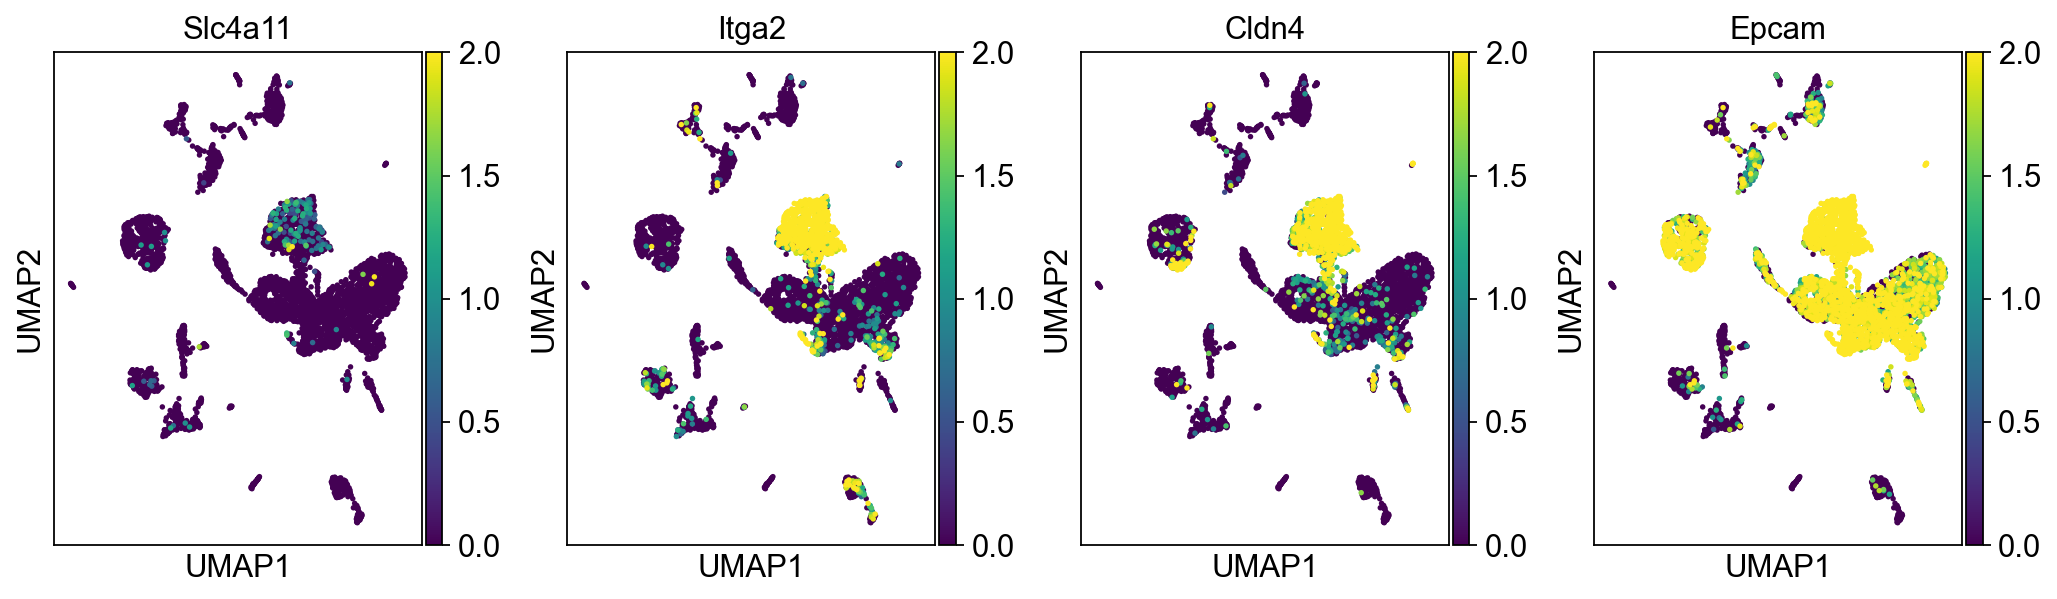

In [66]:
sc.pl.umap(adata, color=['Slc4a11', 'Itga2', 'Cldn4','Epcam'], vmax=2) #'Tigit', 

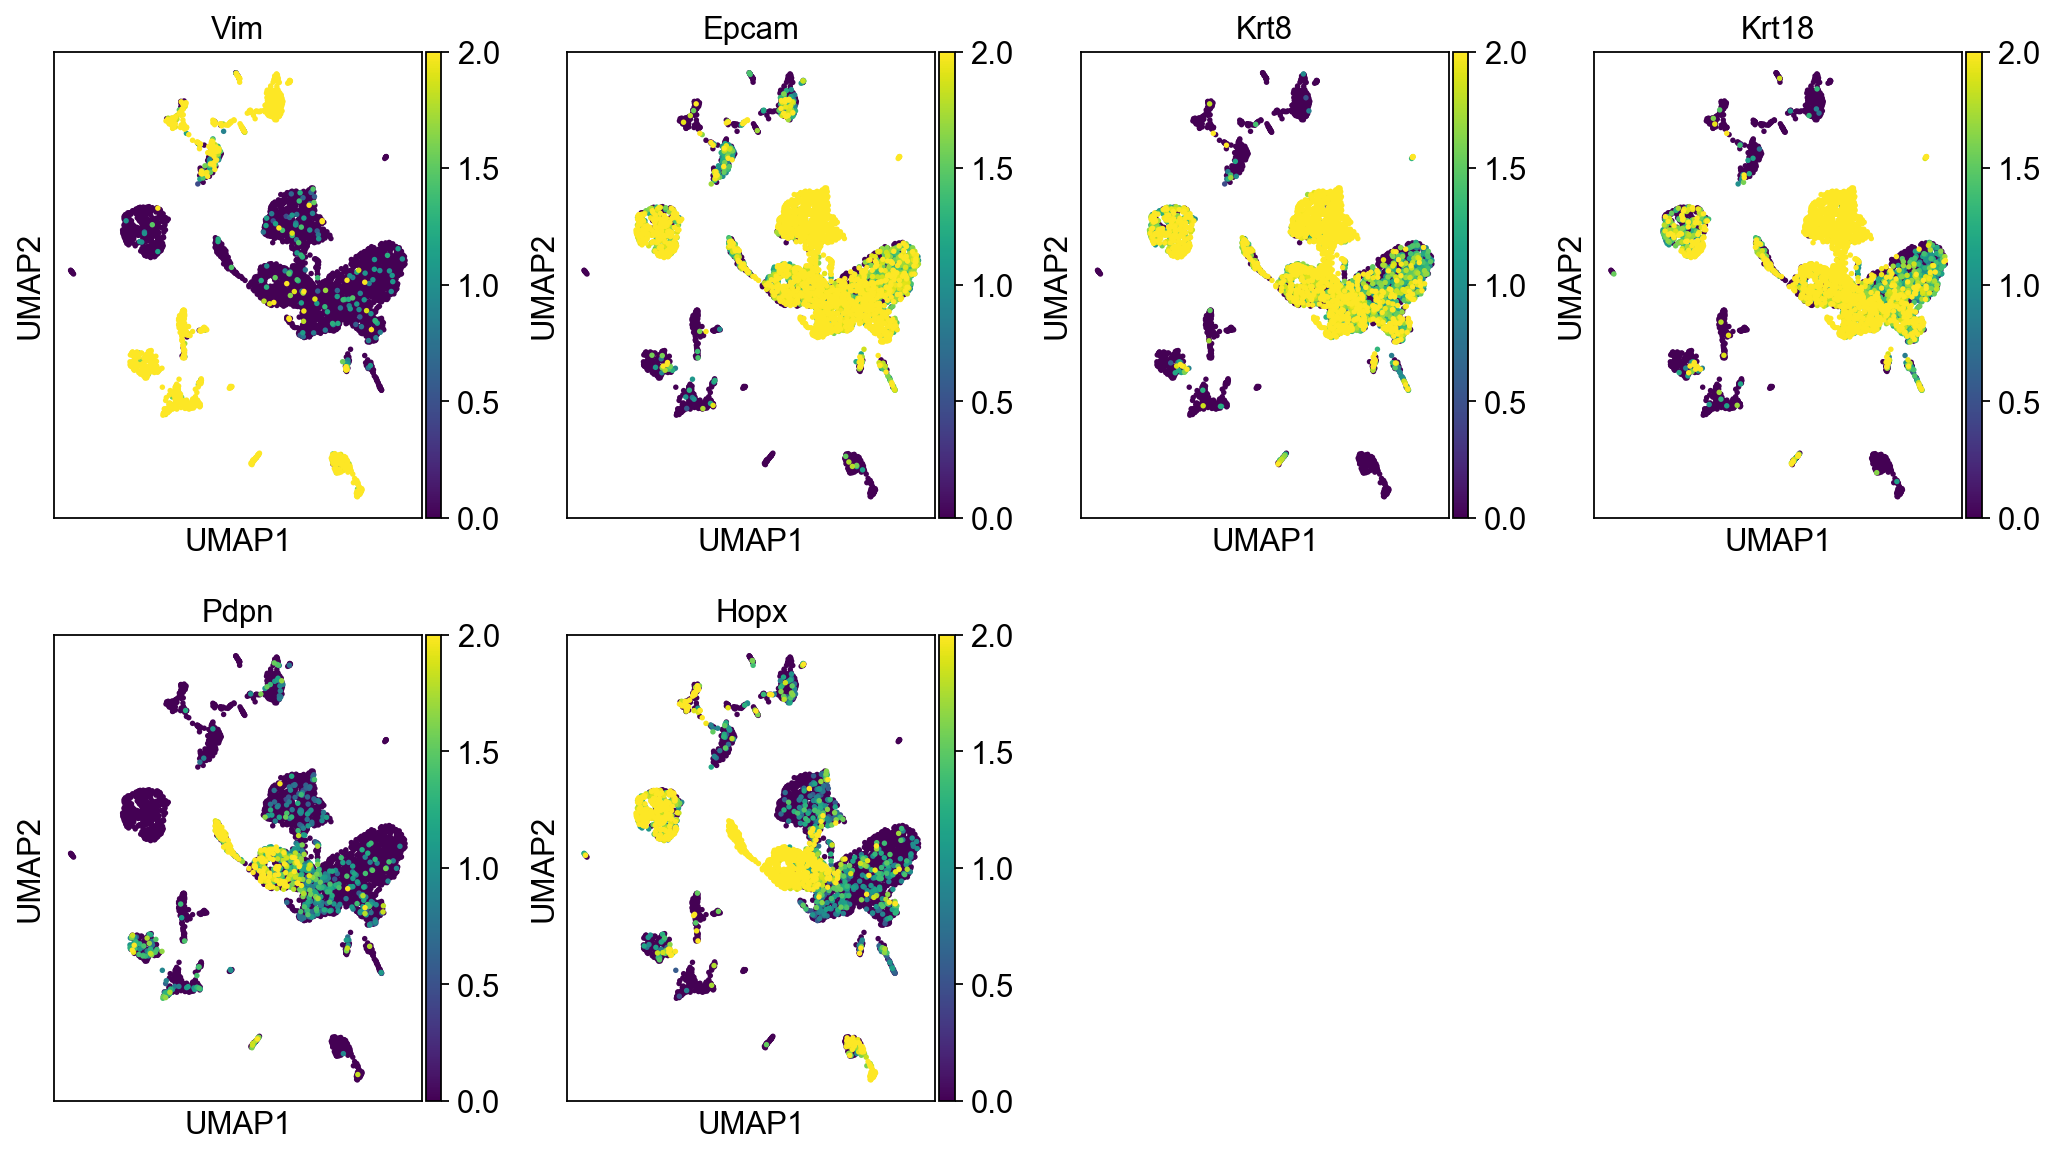

In [67]:
sc.pl.umap(adata, color=['Vim', 'Epcam', 'Krt8', 'Krt18', 'Pdpn', 'Hopx'], vmax=2) #'Pecam1',

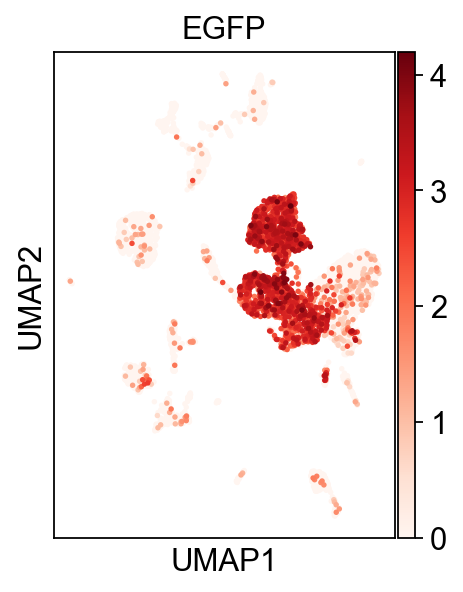

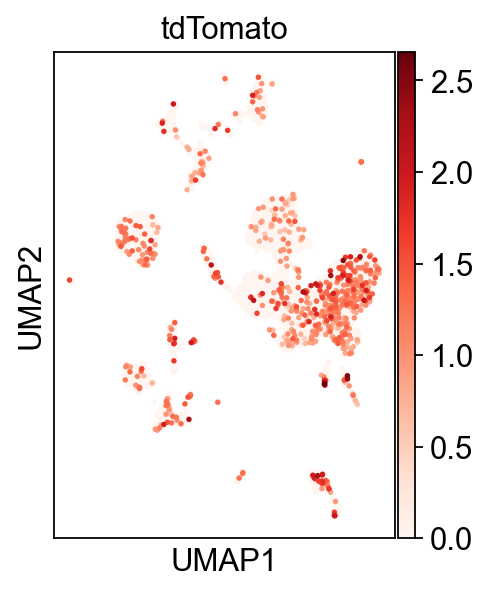

In [68]:
sc.pl.umap(adata, color=['EGFP'], cmap='Reds')
sc.pl.umap(adata, color=['tdTomato'], cmap='Reds')
#sc.pl.umap(adata, color=['ERT'], cmap='Reds')

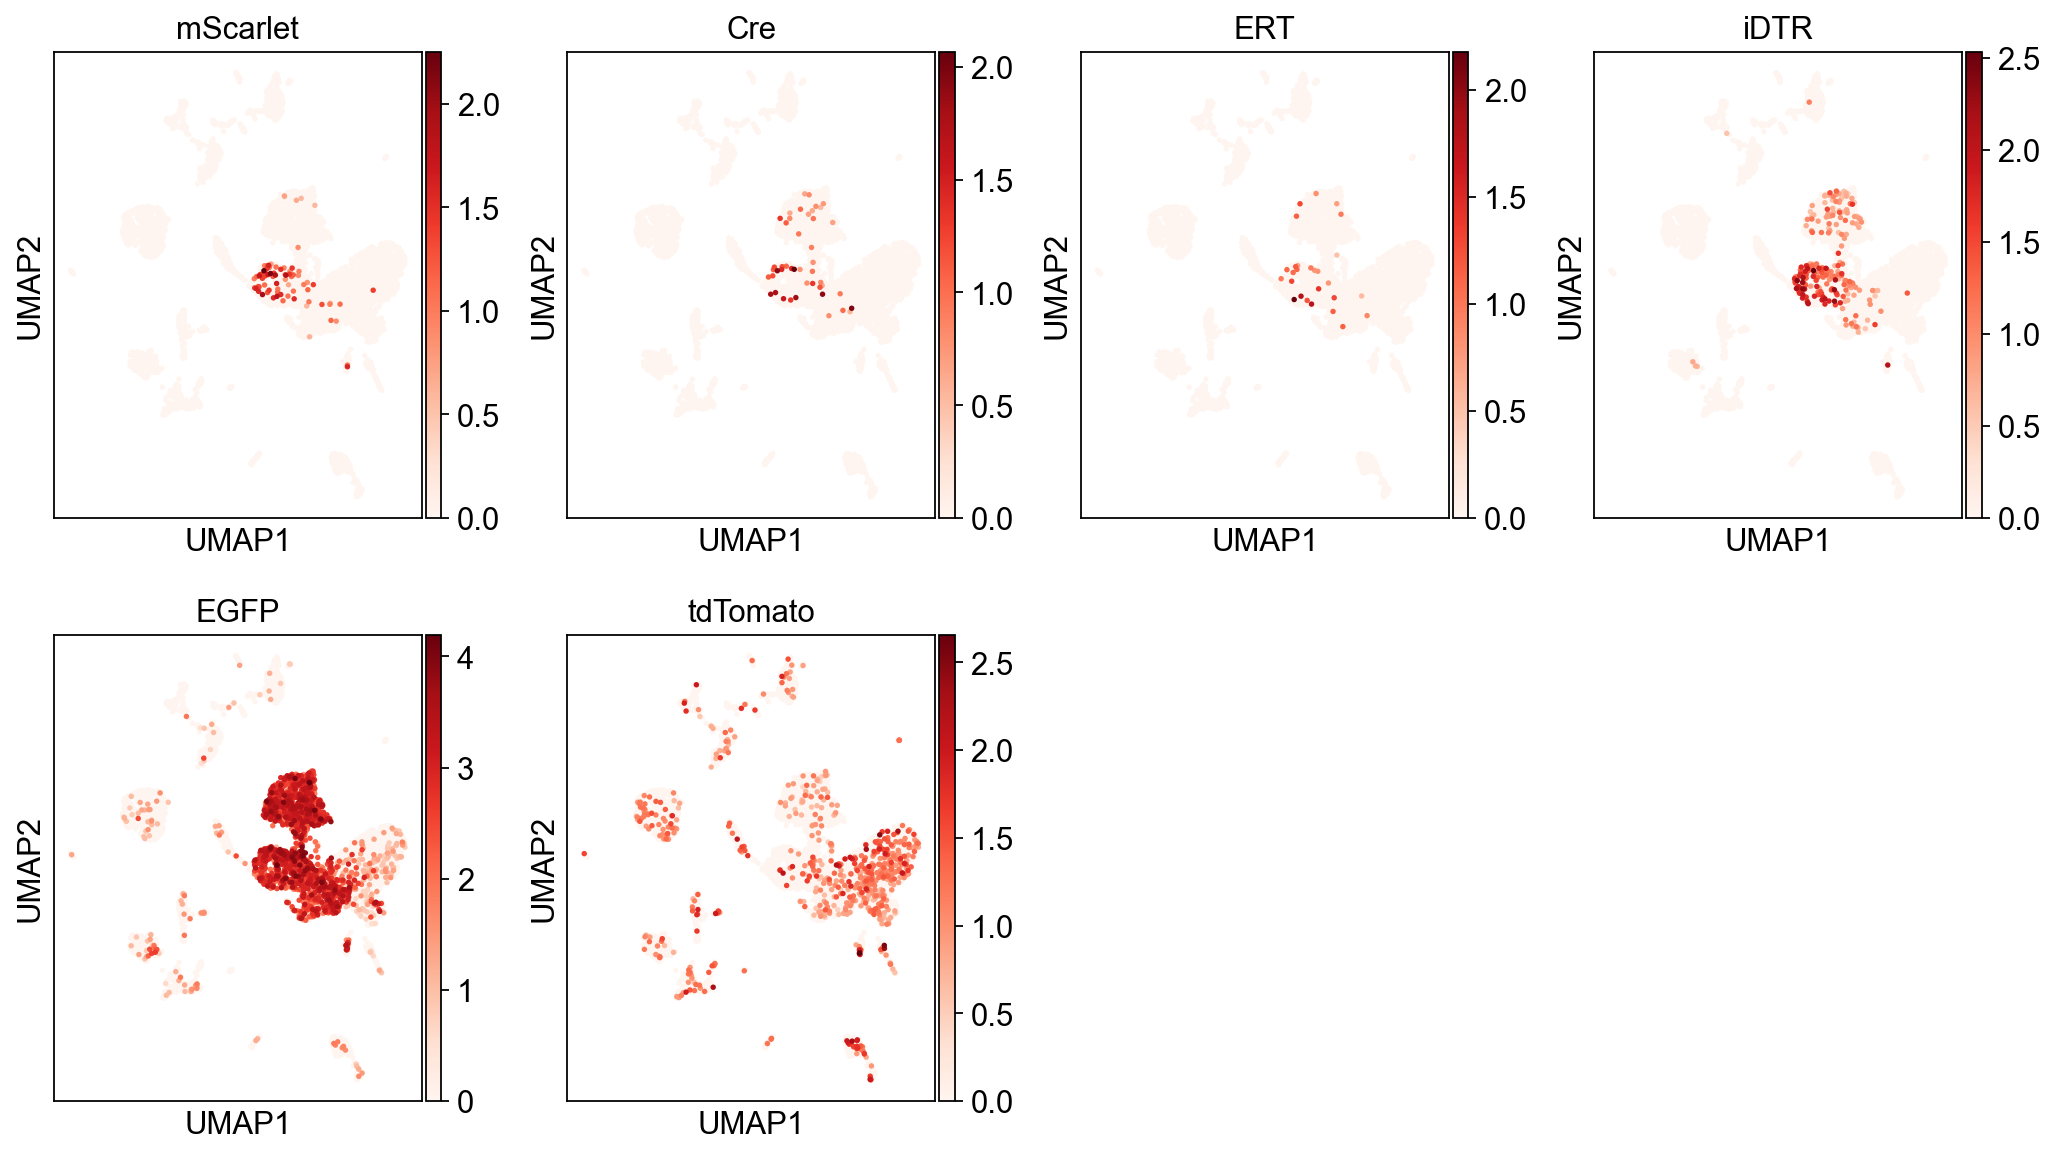

In [69]:
sc.pl.umap(adata, color=["mScarlet", "Cre", "ERT",'iDTR','EGFP','tdTomato'], cmap='Reds') #'mKate2'

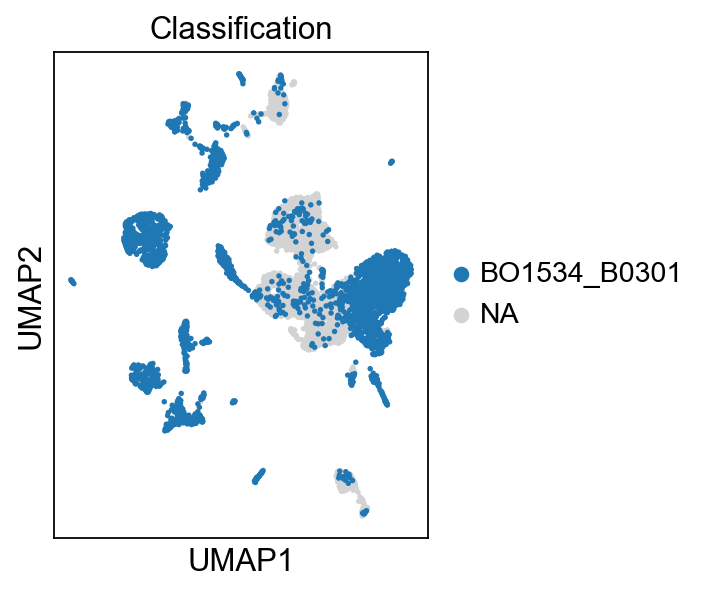

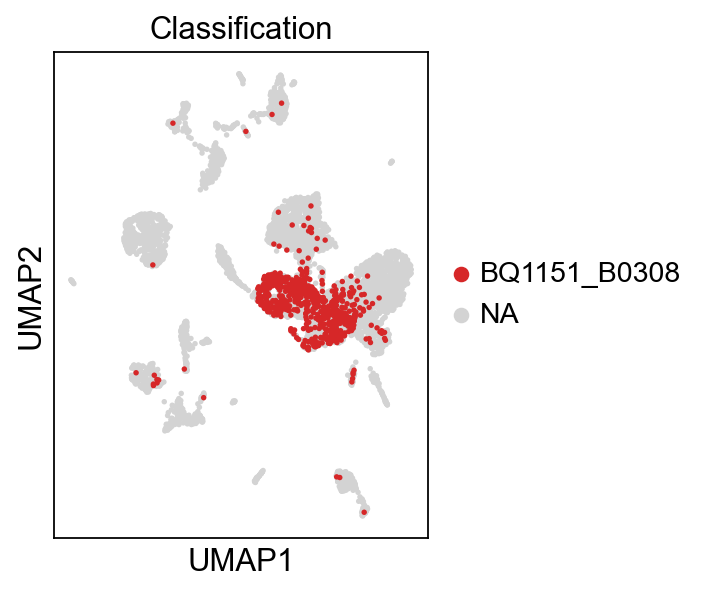

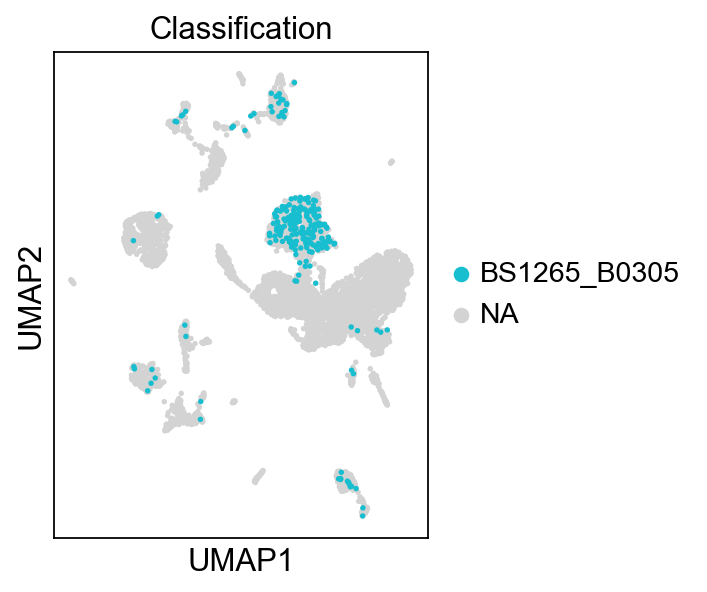

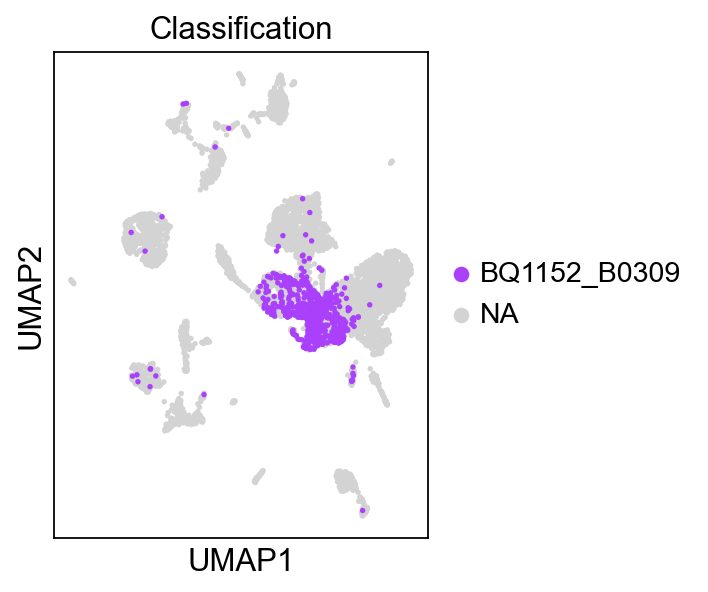

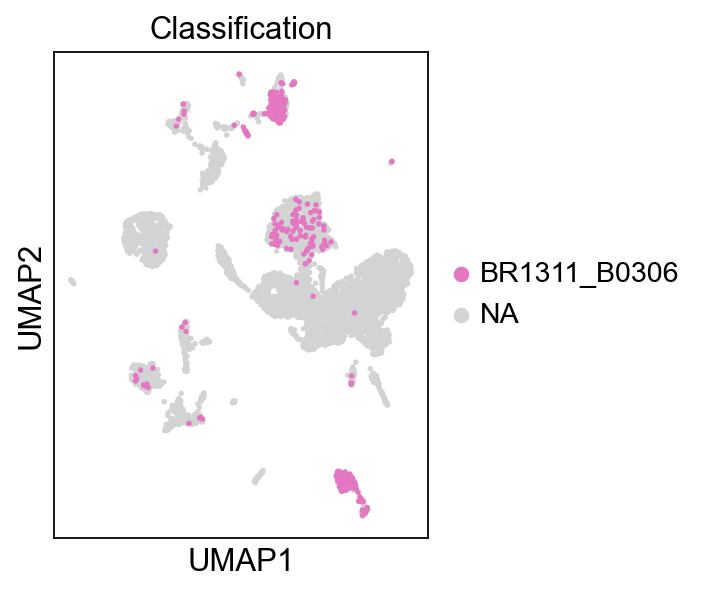

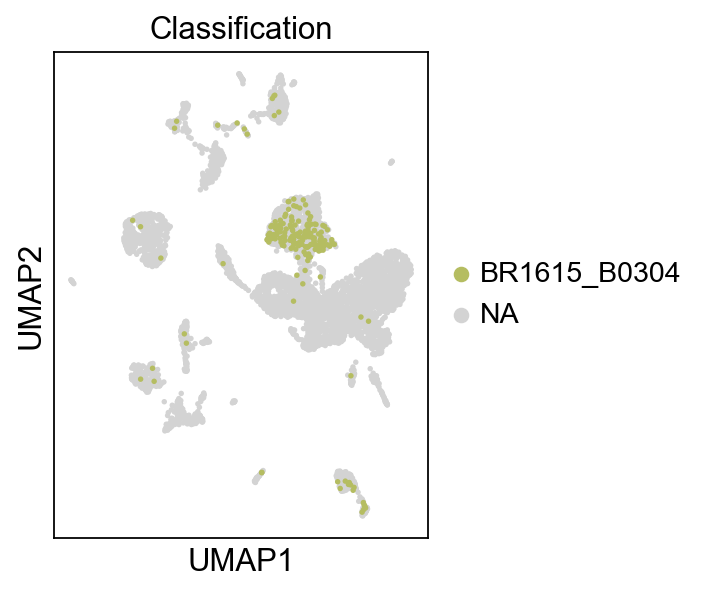

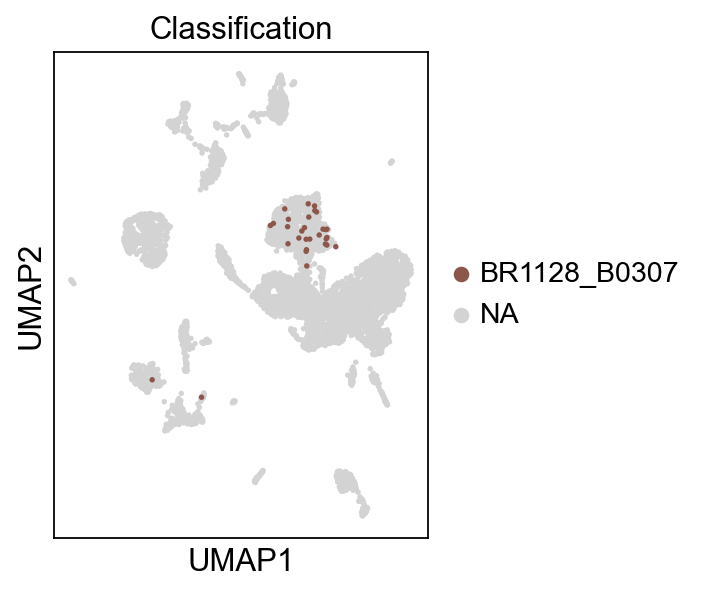

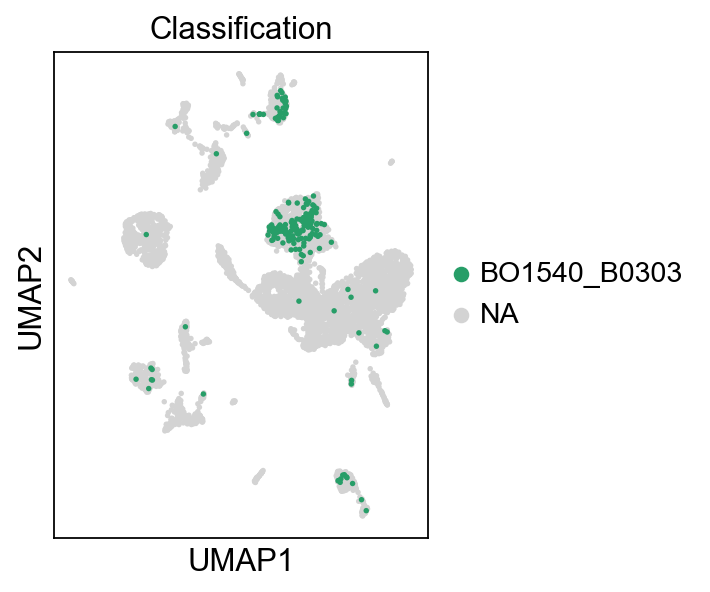

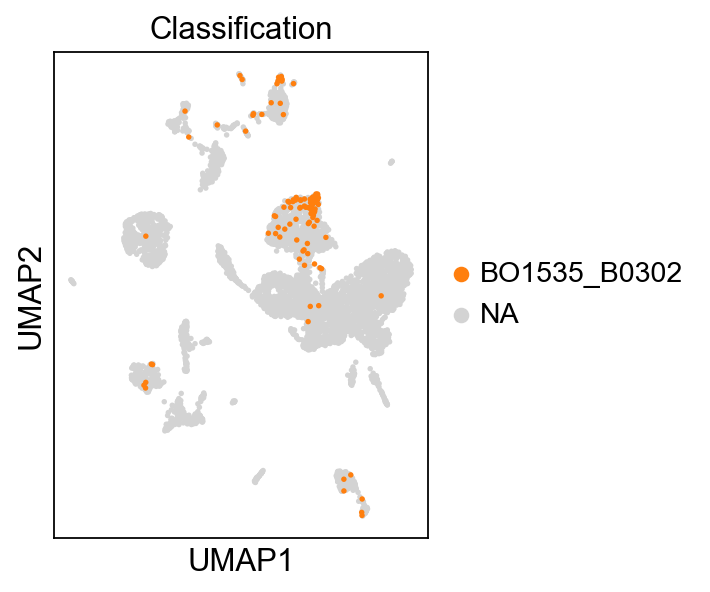

In [70]:
for label in adata.obs['Classification'].unique():
    sc.pl.umap(adata, color='Classification',groups=[label])

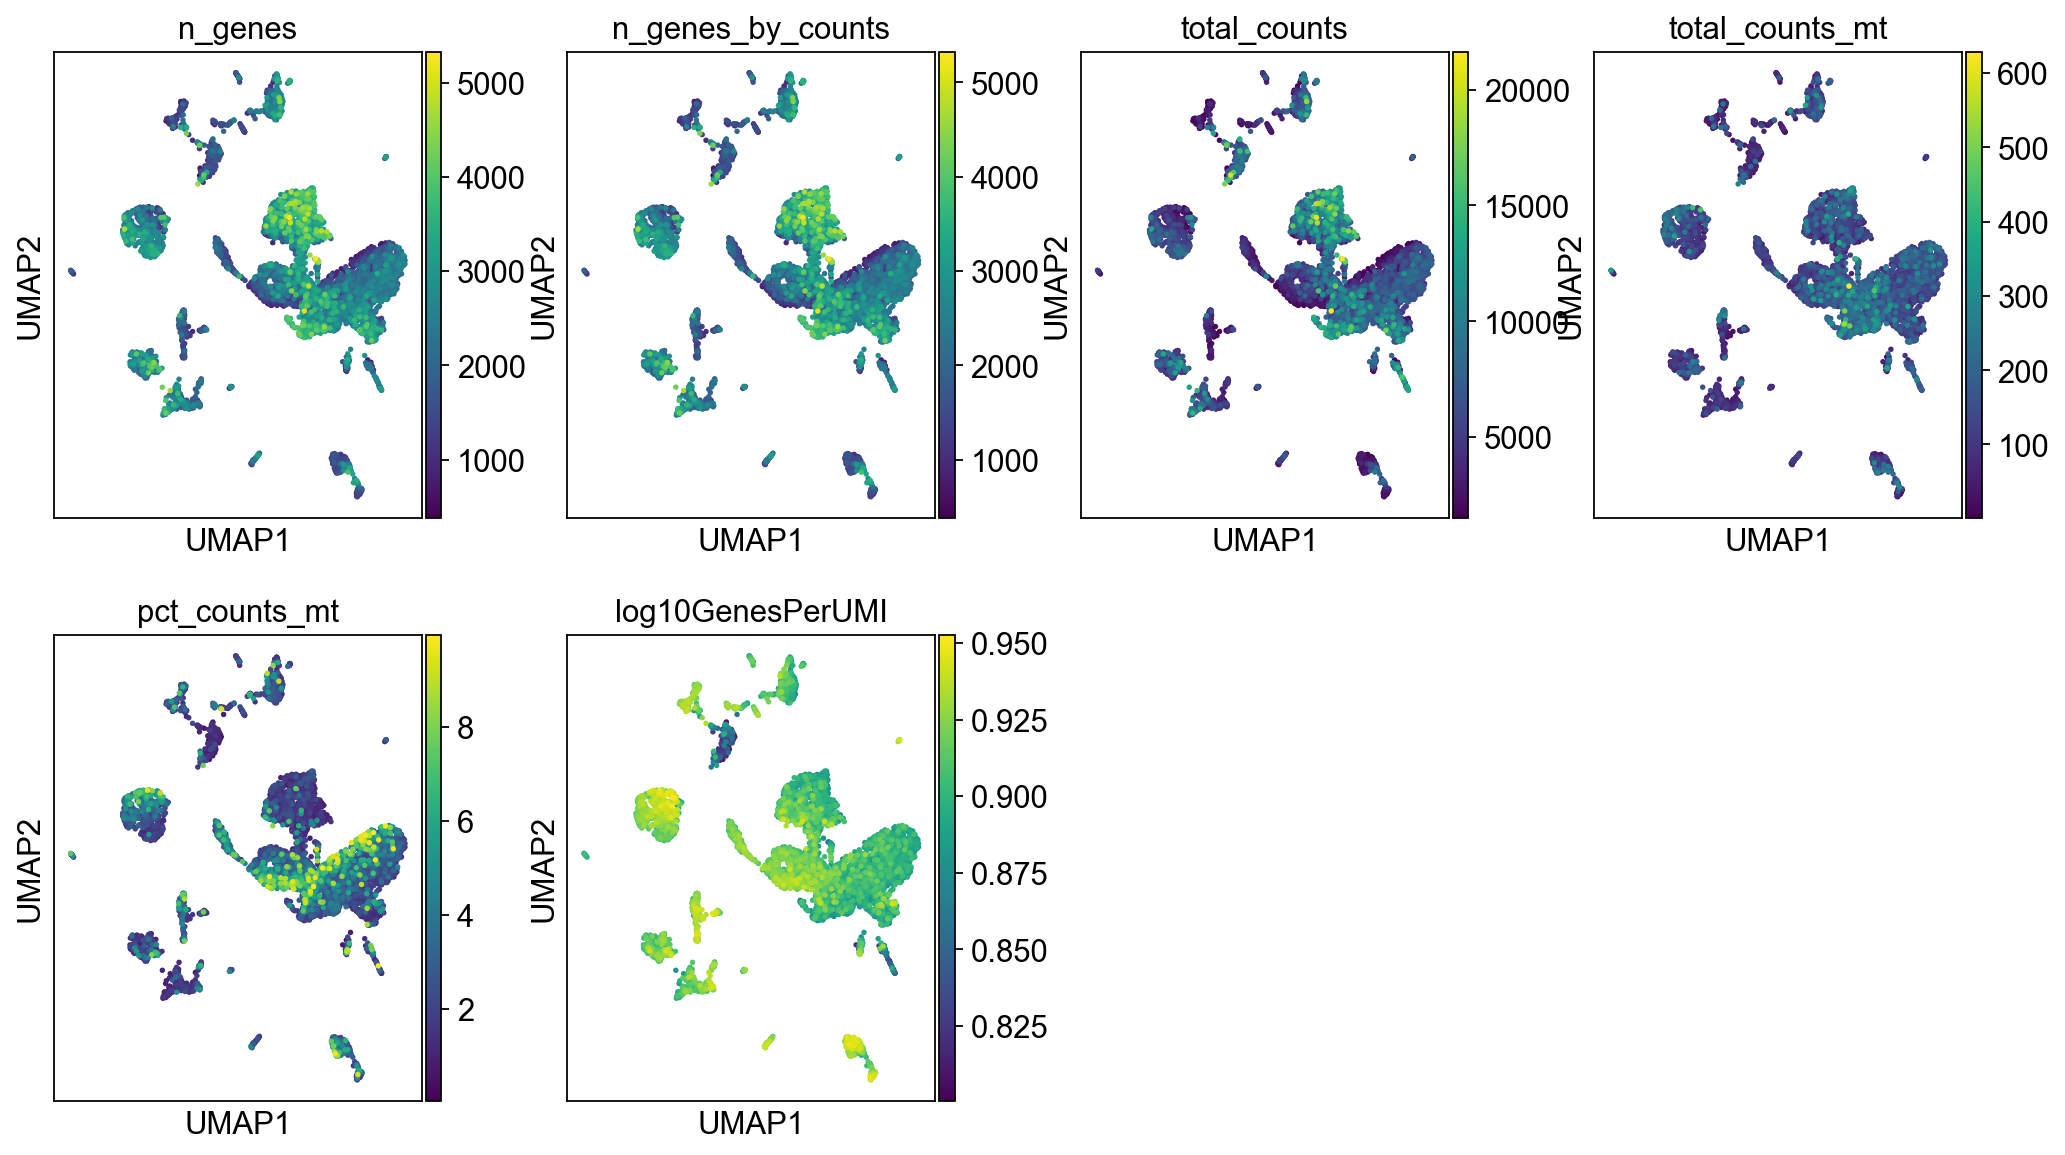

In [71]:
sc.pl.umap(adata,color=['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'log10GenesPerUMI'])

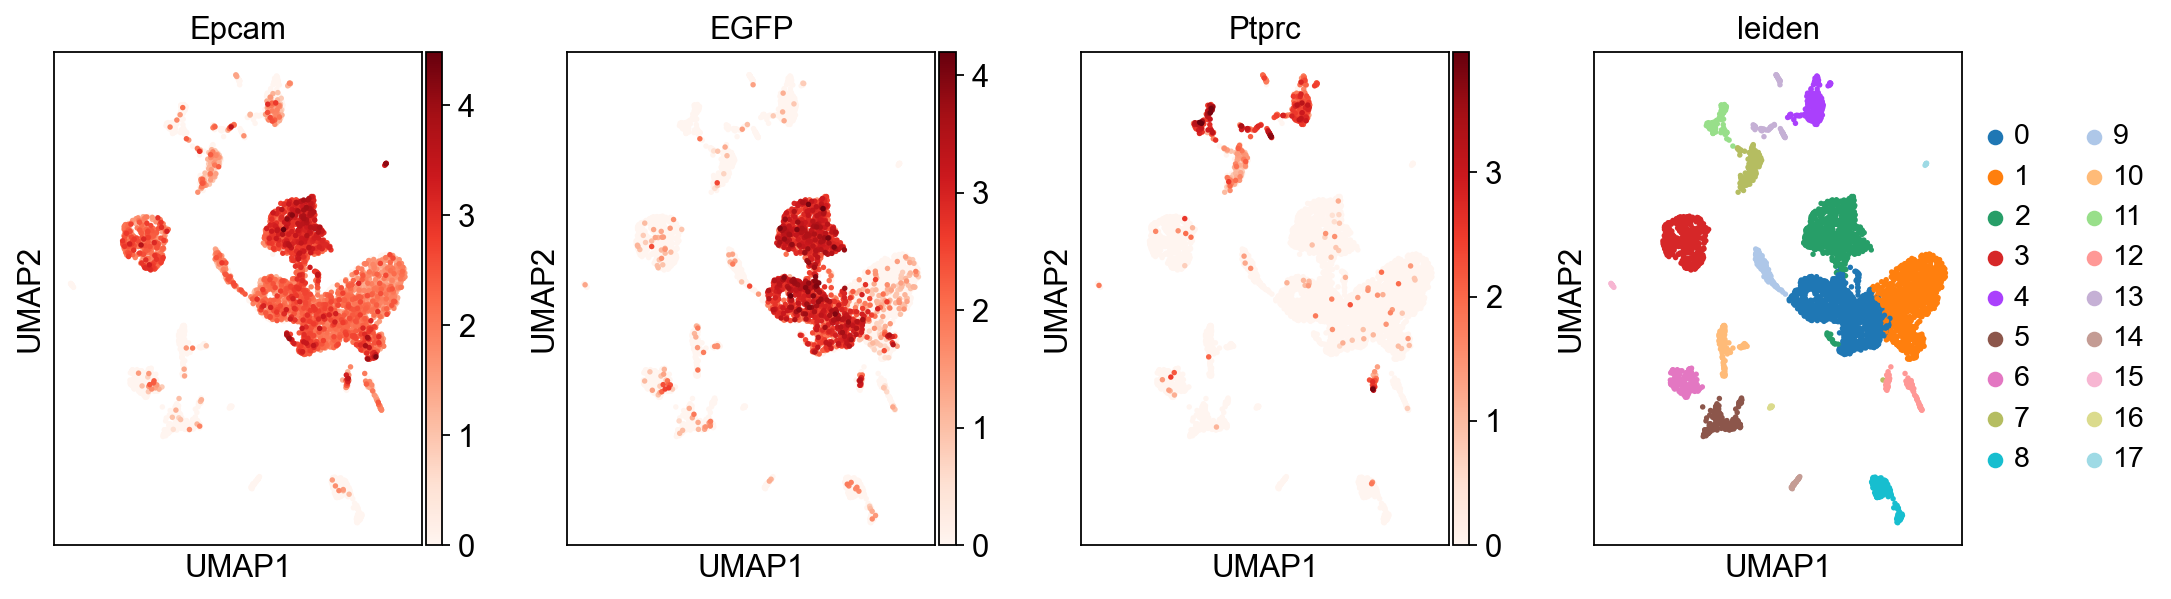

In [72]:
sc.pl.umap(adata, color=['Epcam','EGFP','Ptprc','leiden',],cmap="Reds")

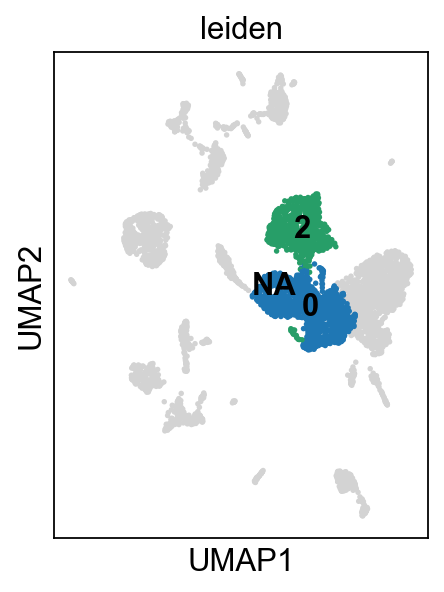

In [73]:
sc.pl.umap(adata, color=['leiden'], groups=['0','2'],legend_loc='on data')

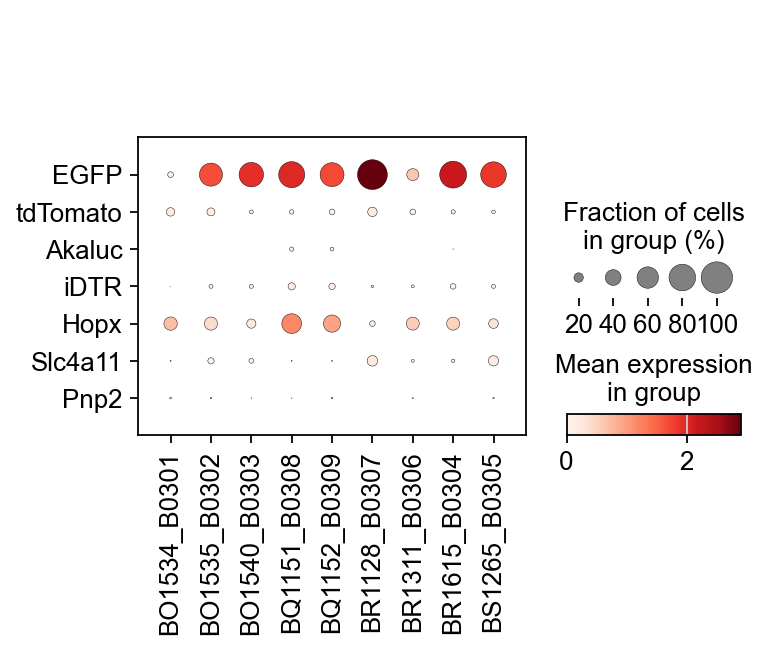

In [74]:
sc.pl.dotplot(adata, ['EGFP','tdTomato','Akaluc','iDTR','Hopx','Slc4a11','Pnp2'],'Classification',swap_axes=True)

In [75]:
# BO1534 is carrier (immune-live+); eventually will need to exclude.
# BR1311 is too high for what should have been sorted and not EGFP enriched; also exclude

## Select Tumor Cells

In [76]:
# Select only those subset of cells that are useful
adata2 = sc.read('write/allmice-IGO17402.h5ad')
adata = adata2[adata.obs['leiden'].isin(['0','2']),:] # keep tumor cells
adata = adata[~adata.obs.Classification.isin(['BO1534_B0301','BR1311_B0306']),:] #exclude non EGFP sorted cells or questionable sorts
del adata2

In [77]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = None

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85349/2000007.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['log1p'] = {}


In [78]:
sc.pp.highly_variable_genes(adata)#, batch_key='Classification')

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [79]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tagBFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Akaluc'] = False
adata.var.highly_variable['tdTomato'] = False
adata.var.highly_variable['CLuc'] = False
adata.var.highly_variable['GLuc'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85349/2833403168.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85349/283340

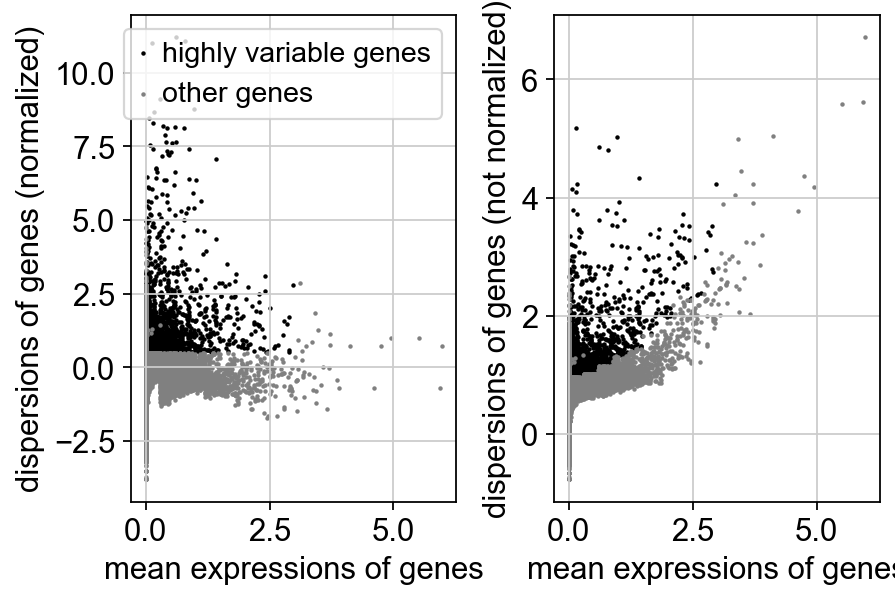

In [80]:
sc.pl.highly_variable_genes(adata)

In [81]:
adata.raw = adata

In [82]:
adata.write('write/allmice-tumor-IGO17402.h5ad', compression='gzip')
#adata = sc.read('write/allmice-tumor.h5ad')